# **IMPORTS**

In [1]:
%%capture 

!pip install -q lightgbm==4.5.0 --no-index --find-links=/kaggle/input/cmi2024-packages-v1/MLPackages
!pip install -q polars==1.7.1 --no-index --find-links=/kaggle/input/cmi2024-packages-v1/Polars171

In [2]:
%%writefile -a myimports.py

print(f"\n---> Commencing imports")

from gc import collect
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.display import display_html, clear_output
clear_output()
import os, sys, logging, re, joblib, ctypes, shutil
from copy import deepcopy

# General library imports:-
from os import path, walk, getpid
from psutil import Process
from collections import Counter
from itertools import product
import ctypes
libc = ctypes.CDLL("libc.so.6")

from IPython.display import display_html, clear_output
from pprint import pprint
from functools import partial
from copy import deepcopy
import pandas as pd, numpy as np
from numpy.typing import ArrayLike, NDArray
import polars as pl
import polars.selectors as cs
from polars.testing import assert_frame_equal

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style, init
from tqdm.notebook import tqdm

Writing myimports.py


In [3]:
%%writefile -a myimports.py

# Importing model and pipeline specifics:-
from category_encoders import OrdinalEncoder, OneHotEncoder

# Pipeline specifics:-
from sklearn.preprocessing import (RobustScaler,
                                   MinMaxScaler,
                                   StandardScaler,
                                   FunctionTransformer as FT,
                                   PowerTransformer,
                                  )
from sklearn.impute import SimpleImputer as SI
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF,
                                     StratifiedKFold as SKF,
                                     StratifiedGroupKFold as SGKF,
                                     KFold,
                                     GroupKFold as GKF,
                                     RepeatedKFold as RKF,
                                     PredefinedSplit as PDS,
                                     cross_val_score,
                                     cross_val_predict,
                                    )
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold as VT
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import (BaseEstimator, TransformerMixin, RegressorMixin, clone)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import (mean_squared_error as mse, 
                             cohen_kappa_score,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                            )

# Importing model packages
import xgboost as xgb, lightgbm as lgb
from xgboost import QuantileDMatrix, XGBRegressor as XGBR
from lightgbm import log_evaluation, early_stopping, LGBMRegressor as LGBMR
from catboost import CatBoostRegressor as CBR, Pool

# Importing Ensemble and tuning packages
import optuna
from optuna import Trial, trial, create_study
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler, CmaEsSampler
optuna.logging.disable_default_handler()

Appending to myimports.py


In [4]:
%%writefile -a myimports.py

# Setting rc parameters in seaborn for plots and graphs-
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        }
       )

# Color printing
def PrintColor(text: str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string"
    print(style + color + text + Style.RESET_ALL)
 
# Checking package versions
import xgboost as xgb, lightgbm as lgb, catboost as cb, sklearn as sk
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}")
print(f"---> Sklearn = {sk.__version__}| Pandas = {pd.__version__} | Polars = {pl.__version__}")
collect()

Appending to myimports.py


In [5]:
%%time
exec(open('myimports.py','r').read())
print()

---> XGBoost = 2.0.3 | LightGBM = 4.5.0 | Catboost = 1.2.7
---> Sklearn = 1.2.2| Pandas = 2.2.2 | Polars = 1.7.1

CPU times: user 2.91 s, sys: 372 ms, total: 3.29 s
Wall time: 4.02 s


# **APPROACH DETAILS**

This is a starter notebook for the **Child Mind Institute — Problematic Internet Use** code competition. This is a time series tabular assignment to detect and classify the impact of excessive internet usage on child sleep patterns. We use **Quadratic Weighted Kappa Score** as evaluation metric. This needs to be maximized <br>

We are provided a set of 3 datasets- <br> 
1. Parquet files for accelerometer train data, with separate tables for each id <br> 
2. Parquet files for accelerometer test data, with separate tables for each id <br>
3. Metadata for remaining information and a separate table for data dictionary <br> 

In this kernel, we start with the metadata and a few aggregate columns from the parquet file only and develop simple ML models as below- <br>
1. The data has targets in 2 steps. In the first step, we make a regression model to predict a proxy target- **PCIAT_Total**. We have 20 target columns from PCIAT_1 - PCIAT_20 and the total column - **PCIAT_Total** <br>
2. We predict each target using a separate model. So we have 21 first level models, one for each of the **PCIAT_1-20** columns and one for **PCIAT_Total**. We calculate PCIAT_Total as a sum of the calculated 20 targets and then blend this with the predicted PCIAT_Total to yield some additional signals in the data <br>
3. In the second step, we split the **PCIAT_Total** column into 4 classes and estimate the actual target for the assignment <br> 

# **CONFIGURATION**

In [6]:
%%writefile -a training.py

# Configuration class:-
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;

    # Data preparation:-
    version_nb  = 1
    model_id    = "V1_3"
    model_label = "ML"

    test_req           = False
    test_sample_frac   = 1000

    gpu_switch         = "OFF"
    state              = 42
    target             = f"sii"
    grouper            = f"sii"

    ip_path            = f"/kaggle/input/child-mind-institute-problematic-internet-use"
    op_path            = f"/kaggle/working"

    # Model Training:-
    pstprcs_oof        = False
    pstprcs_train      = False
    pstprcs_test       = False
    ML                 = True
    test_preds_req     = True

    pseudo_lbl_req     = False
    pseudolbl_up       = 0.975
    pseudolbl_low      = 0.00

    n_splits           = 3 if test_req == "Y" else 5
    n_repeats          = 1
    nbrnd_erly_stp     = 40
    mdlcv_mthd         = 'RSKF'

    # Ensemble:-
    ensemble_req       = True
    optuna_req         = True
    metric_obj         = 'maximize'
    ntrials            = 10 if test_req == "Y" else 300

    # Global variables for plotting:-
    grid_specs = {'visible'  : True,
                  'which'    : 'both',
                  'linestyle': '--',
                  'color'    : 'lightgrey',
                  'linewidth': 0.75
                 }

    title_specs = {'fontsize'   : 9,
                   'fontweight' : 'bold',
                   'color'      : '#992600',
                  }
    
cv_selector = \
{
 "RKF"   : RKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "RSKF"  : RSKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "SKF"   : SKF(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
 "KF"    : KFold(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
}

PrintColor(f"\n---> Configuration done!\n")
collect()

Writing training.py


|Configuration parameter| Explanation| Data type| Sample values |  
| ---------------------- | ------------------------------- | --------------------- | --------------- |
| version_nb    | Version Number | int | 1 | 
| model_id      | Model ID    | string | V1_1 | 
| model_label   | Model Label | string | ML | 
| test_req      | Test Required| bool | True / False | 
| test_sample_frac| Test sampled fraction | int | 1000 |
| gpu_switch      | Do we need GPU support | bool | True / False |
| state           | Random state | int | 42 |
| target          | Target column | str | sii |
| grouper         | CV grouper column | str | sii |
| ip_path, op_path | Data paths  | str | |
| pstprcs_* | Do we need post-processing  | bool |True / False |
| ML| Do we need machine learning models  | bool |True / False |
| test_preds_req| Do we need test set predictions (training in inference kernel)  | bool |True / False |
| pseudo_lbl_req| Pseudo label required?  | bool |True / False |
| pseudo_lbl_* | Pseudo label cutoff | float | |
| n_splits/ n_repeats | N-splits and repeats for CV scheme | int | 3/5/10|
| nbrnd_erly_stp | Early stopping rounds | int | 40|
| mdlcv_mthd | Model CV method | str | RSKF|
| ensemble_req | Do we need ensemble | bool | True / False |
| optuna_req   | Do we need optuna | bool | True / False |
| metric_obj   | Metric direction | str | minimize/ maximize |
| ntrials      | Trials | int | 300 |

In [7]:
%%writefile -a training.py

class Utils:
    """
    This class creates and uses several utility methods to be used across the code
    """;

    def __init__(self):
        pass

    def ScoreMetric(self, ytrue, ypred)-> float:
        """
        This method calculates the metric for the competition
        Inputs- ytrue, ypred:- input truth and predictions
        Output- float:- competition metric
        """
        return cohen_kappa_score(ytrue, ypred, weights = "quadratic")

    def CleanMemory(self):
        "This method cleans the memory off unused objects and displays the cleaned state RAM usage"

        collect();
        libc.malloc_trim(0)
        pid        = getpid()
        py         = Process(pid)
        memory_use = py.memory_info()[0] / 2. ** 30
        return f"\nRAM usage = {memory_use :.4} GB"

    def DisplayAdjTbl(self, *args):
        """
        This function displays pandas tables in an adjacent manner, sourced from the below link-
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        """

        html_str = ''
        for df in args:
            html_str += df.to_html()
        display_html(html_str.replace('table','table style="display:inline"'),raw=True)
        collect()

    def DisplayScores(
        self, Scores: pd.DataFrame, TrainScores: pd.DataFrame, methods: list
    ):
        "This method displays the scores and their means"

        args = \
        [Scores.style.format(precision = 5).\
         background_gradient(cmap = "Blues", subset = methods + ["Ensemble"]).\
         set_caption(f"\nOOF scores across methods and folds\n"),

         TrainScores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = methods).\
         set_caption(f"\nTrain scores across methods and folds\n")
        ];

        PrintColor(f"\n\n\n---> OOF score across all methods and folds\n",
                   color = Fore.LIGHTMAGENTA_EX
                   )
        self.DisplayAdjTbl(*args)

        print('\n')
        display(Scores.mean().to_frame().\
                transpose().\
                style.format(precision = 5).\
                background_gradient(cmap = "mako", axis=1,
                                    subset = Scores.columns
                                   ).\
                set_caption(f"\nOOF mean scores across methods and folds\n")
               )


utils = Utils()
collect()
print()

Appending to training.py


# **PREPROCESSING**

In [8]:
%%writefile -a training.py

def MakeAggs(
    all_files: list, verbose: bool = False, ip_path: str = CFG.ip_path,
)->pl.DataFrame:
    "This function collates the id level parquet files and creates the aggregation columns in a polars dataframe"
    
    cols = ["X", "Y", "Z", "enmo", "anglez", "light", "battery_voltage"]
    
    for file_nb, file in enumerate(all_files):
        df = \
        pl.scan_parquet(
            os.path.join(ip_path, file)
        ).select(pl.col(cols)).\
        collect().\
        describe(
            percentiles = np.arange(0.05, 0.95, 0.10)
        ).\
        filter(~pl.col("statistic").is_in(["count", "null_count"])).\
        unpivot(index = "statistic").\
        with_columns(
            pl.concat_str([pl.col("variable"), pl.col("statistic")],separator = "_",).alias("myvar")
        ).\
        with_columns(pl.col("myvar").str.replace(r"\%", "")).\
        select(["myvar", "value"]).\
        transpose(column_names = "myvar").\
        select(pl.all().shrink_dtype()).\
        with_columns(
            pl.Series("id", np.array(re.sub("id=", "", file)))
        )

        if file_nb == 0:
            op_df = df.clone()
        elif file_nb > 0:
            op_df = pl.concat([op_df, df], how = "vertical_relaxed")
            
            if verbose:
                print(f"---> Shapes = {op_df.shape}")
            else:
                pass
        del df
    
    print(f"---> Shape = {op_df.shape}")
    return op_df


Appending to training.py


In [9]:
%%time 

exec(open('training.py','r').read())
train  = pl.read_csv(os.path.join(CFG.ip_path, "train.csv")).drop("PCIAT-Season")
test   = pl.read_csv(os.path.join(CFG.ip_path, "test.csv"))
sub_fl = pl.read_csv(os.path.join(CFG.ip_path, "sample_submission.csv"))

PrintColor(f"---> Data Processing")
print(f"---> Shapes = {train.shape} {test.shape}")

cat_cols = train.select(cs.string().exclude("id")).columns
train = train.with_columns(pl.col(cat_cols).fill_null("missing").cast(pl.Categorical))
test  = test.with_columns(pl.col(cat_cols).fill_null("missing").cast(pl.Categorical))

targets  = \
sorted(
    list(
        set(train.columns).difference(set(test.columns)).difference(set([CFG.target]))
    )
)

# Adding parquet file columns:- 
all_files = os.listdir(os.path.join(CFG.ip_path, f"series_train.parquet"))
op_df = MakeAggs(all_files, verbose = False, 
                 ip_path = os.path.join(CFG.ip_path, f"series_train.parquet")
                )
train = train.join(op_df, how = "left", on = "id")
del op_df

all_files = os.listdir(os.path.join(CFG.ip_path, f"series_test.parquet"))
op_df = MakeAggs(all_files, verbose = False, 
                 ip_path = os.path.join(CFG.ip_path, f"series_test.parquet")
                )
test  = test.join(op_df, how = "left", on = "id")
del op_df

sel_cols = test.drop("id").columns
train    = train.select(pl.all().shrink_dtype())
test     = test.select(pl.all().shrink_dtype())
PrintColor(f"---> Shapes = {train.shape} {test.shape}\n")

with np.printoptions(linewidth = 100):
    PrintColor(f"\n---> All targets")
    pprint(np.array(targets))
    PrintColor(f"\n---> All category columns")
    pprint(np.array(cat_cols))    
    
PrintColor(utils.CleanMemory())


---> Configuration done!


---> Data Processing
---> Shapes = (3960, 81) (20, 59)
---> Shape = (996, 92)
---> Shape = (2, 92)
---> Shapes = (3960, 172) (20, 150)


---> All targets
array(['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05',
       'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
       'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
       'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20',
       'PCIAT-PCIAT_Total'], dtype='<U17')

---> All category columns
array(['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season',
       'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season',
       'PreInt_EduHx-Season'], dtype='<U25')

RAM usage = 0.5145 GB
CPU times: user 5min 23s, sys: 12.3 s, total: 5min 36s
Wall time: 2min 17s


# **MODEL TRAINING**

In [10]:
%%writefile -a training.py

class ModelTrainer:
    "This class trains the provided model on the train-test data and returns the predictions and fitted models"

    def __init__(
        self,
        es             : int   = 100,
        target         : str   = CFG.target,
        metric_lbl     : str   = "rmse",
        drop_cols      : list  = ["Source", "id", "Id", "Label", CFG.target, "fold_nb"],
    ):
        """
        Key parameters-
        es_iter - early stopping rounds for boosted trees
        """
        self.es_iter        = es
        self.target         = target
        self.drop_cols      = drop_cols
        self.metric_lbl     = metric_lbl


    def ScoreMetric(self, ytrue, ypred)->float:
        """
        This is the metric function for the competition scoring
        """
        if self.metric_lbl == "rmse":
            return mse(ytrue, ypred, squared = False)
        
        elif self.metric_lbl == "kappa":
            myscore = \
            cohen_kappa_score(
                np.uint8(np.around(ytrue,0)),
                np.uint8(np.around(ypred,0)),
                weights = "quadratic",
            )
            return myscore

    def PlotFtreImp(
        self, ftreimp: pd.Series, method: str,
        ntop: int = 50,
        title_specs: dict = CFG.title_specs,
        **params,
    ):
        "This function plots the feature importances for the model provided"

        print()
        fig, ax = plt.subplots(1, 1, figsize = (25, 7.5))

        ftreimp.sort_values(ascending = False).\
        head(ntop).\
        plot.bar(ax = ax, color = "blue")
        ax.set_title(f"Feature Importances - {method}", **title_specs)

        plt.tight_layout()
        plt.show()
        print()

    def PostProcessPreds(self, ypred):
        "This method post-processes predictions optionally"
        return ypred

    def MakeOfflineModel(
        self, X, y, ygrp, Xtest, mdl, method,
        test_preds_req   : bool = True,
        ftreimp_plot_req : bool = True,
        ntop             : int  = 50,
        **params,
    ):
        """
        This function trains the provided model on the dataset and cross-validates appropriately

        Inputs-
        X, y, ygrp       - training data components
        Xtest            - test data
        model            - model object for training
        method           - model method label
        test_preds_req   - boolean flag to extract test set predictions
        ftreimp_plot_req - boolean flag to plot tree feature importances
        ntop             - top n features for feature importances plot

        Returns-
        oof_preds, test_preds - prediction arrays
        fitted_models         - fitted model list for test set
        ftreimp               - feature importances across selected features
        mdl_best_iter         - model average best iteration across folds
        """

        oof_preds     = np.zeros(len(X))
        test_preds    = []
        mdl_best_iter = []
        ftreimp       = 0
        
        scores, tr_scores, fitted_models = [], [], []
        cv = PDS(ygrp)
        n_splits = ygrp.nunique()

        for fold_nb, (train_idx, dev_idx) in tqdm(enumerate(cv.split(X, y))):
            Xtr   = X.iloc[train_idx]
            Xdev  = X.iloc[dev_idx]
            ytr   = y.iloc[train_idx]
            ydev  = y.iloc[dev_idx]
            model = clone(mdl)

            if "CB" in method:
                model.fit(Xtr, ytr,
                          eval_set = [(Xdev, ydev)],
                          verbose = 0,
                          early_stopping_rounds = self.es_iter,
                          )
                best_iter = model.get_best_iteration()

            elif "LGB" in method:
                model.fit(Xtr, ytr,
                          eval_set = [(Xdev, ydev)],
                          callbacks = [log_evaluation(0),
                                       early_stopping(stopping_rounds = self.es_iter, verbose = False,),
                                       ],
                          )
                best_iter = model.best_iteration_

            elif "XGB" in method:
                model.fit(Xtr, ytr,
                          eval_set = [(Xdev, ydev)],
                          verbose  = 0,
                          )
                best_iter = model.best_iteration

            else:
                model.fit(Xtr, ytr)
                best_iter = -1

            fitted_models.append(model)

            try:
                ftreimp += model.feature_importances_
            except:
                pass

            dev_preds = self.PostProcessPreds(model.predict(Xdev))
            oof_preds[Xdev.index] = dev_preds

            train_preds  = self.PostProcessPreds(model.predict(Xtr))
            tr_score     = self.ScoreMetric(ytr.values.flatten(), train_preds)
            score        = self.ScoreMetric(ydev.values.flatten(), dev_preds)

            scores.append(score)
            tr_scores.append(tr_score)

            nspace = 15 - len(method) - 2 if fold_nb <= 9 else 15 - len(method) - 1
            PrintColor(f"{method} Fold{fold_nb} {' ' * nspace} OOF = {score:.6f} | Train = {tr_score:.6f} | Iter = {best_iter:,.0f} ")
            mdl_best_iter.append(best_iter)

            if test_preds_req:
                test_preds.append(
                    self.PostProcessPreds(
                        model.predict(Xtest)
                    )
                )
            else:
                pass

        test_preds    = np.mean(np.stack(test_preds, axis = 1), axis=1)
        ftreimp       = pd.Series(ftreimp, index = Xdev.columns)
        mdl_best_iter = np.uint16(np.amax(mdl_best_iter))

        if ftreimp_plot_req :
            print()
            self.PlotFtreImp(ftreimp, method = method, ntop = ntop,)
        else:
            pass

        PrintColor(f"\n---> {np.mean(scores):.6f} +- {np.std(scores):.6f} | OOF", color = Fore.RED)
        PrintColor(f"---> {np.mean(tr_scores):.6f} +- {np.std(tr_scores):.6f} | Train", color = Fore.RED)

        if mdl_best_iter < 0:
            pass
        else:
            PrintColor(f"---> Max best iteration = {mdl_best_iter :,.0f}", color = Fore.RED)

        return (fitted_models, oof_preds, test_preds, ftreimp, mdl_best_iter)

    def MakeOnlineModel(
        self, X, y, Xtest, model, method,
        test_preds_req : bool = False,
    ):
        "This method refits the model on the complete train data and returns the model fitted object and predictions"

        try:
            model.early_stopping_rounds = None
        except:
            pass

        try:
            model.fit(X, y, verbose = 0)
        except:
            model.fit(X, y,)

        oof_preds  = model.predict(X)
        if test_preds_req:
            test_preds = model.predict(Xtest[X.columns])
        else:
            test_preds = 0
        return (model, oof_preds, test_preds)

    def MakeOfflinePreds(self, X, fitted_models):
        "This method creates test-set predictions for the offline model provided"

        test_preds = 0
        n_splits   = len(fitted_models)
        PrintColor(f"---> Number of splits = {n_splits}")

        for model in fitted_models:
            test_preds = test_preds + (model.predict(X) / n_splits)

        return test_preds

Appending to training.py


In [11]:
%%writefile -a training.py

class OptunaEnsembler:
    """
    This is the Optuna ensemble class-
    Source- https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass
    """;

    def __init__(
        self, state: int = 42, ntrials: int = 300, 
        metric_obj: str = "maximize", 
        metric_lbl: str = "rmse",
        **params
    ):
        self.study        = None
        self.weights      = None
        self.random_state = state
        self.n_trials     = ntrials
        self.direction    = metric_obj
        self.metric_lbl   = metric_lbl

    def ScoreMetric(self, ytrue, ypred)->float:
        """
        This is the metric function for the competition
        """
        
        if self.metric_lbl == "rmse":
            return mse(ytrue, ypred, squared = False)
        else:
            myscore = \
            cohen_kappa_score(
                np.uint8(np.around(ytrue,0)),
                np.uint8(np.around(ypred,0)), 
                weights = "quadratic"
            )
            return myscore

    def _objective(
        self, trial, y_true, y_preds
    ):
        """
        This method defines the objective function for the ensemble
        """;

        if isinstance(y_preds, pd.DataFrame) or isinstance(y_preds, np.ndarray):
            weights = [trial.suggest_float(f"weight{n}", 0.001, 0.999)
                       for n in range(y_preds.shape[-1])
                      ]
            axis = 1

        elif isinstance(y_preds, list):
            weights = [trial.suggest_float(f"weight{n}", 0.001, 0.999)
                       for n in range(len(y_preds))
                      ]
            axis = 0

        # Calculating the weighted prediction:-
        weighted_pred  = np.average(np.array(y_preds), axis = axis, weights = weights)
        score          = self.ScoreMetric(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        "This method fits the Optuna objective on the fold level data";

        optuna.logging.set_verbosity = optuna.logging.ERROR

        self.study = \
        optuna.create_study(sampler    = TPESampler(seed = self.random_state),
                            pruner     = HyperbandPruner(),
                            study_name = "Ensemble",
                            direction  = self.direction,
                           )

        obj = partial(self._objective, y_true = y_true, y_preds = y_preds)
        self.study.optimize(obj, n_trials = self.n_trials)

        if isinstance(y_preds, list):
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

        else:
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(y_preds.shape[-1])]

    def predict(self, y_preds):
        "This method predicts using the fitted Optuna objective";

        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict';

        if isinstance(y_preds, list):
            weighted_pred = np.average(np.array(y_preds), axis=0, weights = self.weights)

        else:
            weighted_pred = np.average(np.array(y_preds), axis=1, weights = self.weights)

        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        """
        This method fits the Optuna objective on the fold data, then predicts the test set
        """;
        self.fit(y_true, y_preds)
        return self.predict(y_preds)

    def weights(self):
        "This method returns the non-normalized weights for all models in a fold"
        return self.weights

print()
collect();

Appending to training.py


In [12]:
%%writefile -a training.py

def NormWeights(weights: dict, methods: list):
    "This function normalizes the weights and returns a dataframe of normalized weights across folds and models"

    weights = pd.DataFrame.from_dict(weights).T
    weights["row_sum"] = weights.sum(axis=1)

    for col in weights.columns:
        weights[col] = weights[col] / weights["row_sum"]

    weights.drop("row_sum", axis = 1, inplace = True, errors = "ignore")
    weights.columns    = methods
    weights.index.name = "Fold_Nb"
    return weights

def MakeEnsemble(
    target: str, metric_obj: str, metric_lbl: str = "rmse"
):
    "This function implements the Optuna ensemble on the OOF and test prediction datasets"

    global OOF_Preds, Mdl_Preds

    PrintColor(f"\n{'=' * 20} ENSEMBLE {'=' * 20}\n")
    
    ygrp       = OOF_Preds["fold_nb"]
    cv         = PDS(ygrp)
    oof_preds  = np.zeros(len(OOF_Preds))
    test_preds = []
    scores     = []
    weights    = {}
    drop_cols  = ["fold_nb", target, "Ensemble"]
    n_splits   = ygrp.nunique()

    for fold_nb, (_, dev_idx) in tqdm(enumerate(cv.split(OOF_Preds, OOF_Preds[target]))):
        Xdev = OOF_Preds.iloc[dev_idx].drop(drop_cols, axis=1, errors = "ignore")
        ydev = OOF_Preds.loc[dev_idx, target]

        ens = OptunaEnsembler(
            ntrials = CFG.ntrials, metric_lbl = metric_lbl, metric_obj = metric_obj
        )
        ens.fit(ydev, Xdev,)

        dev_preds = ens.predict(Xdev)
        score     = ens.ScoreMetric(ydev.values, dev_preds)
        oof_preds[dev_idx] = dev_preds
        test_preds.append(
            ens.predict(Mdl_Preds.drop(drop_cols, axis=1, errors = "ignore"))
        )

        PrintColor(f"---> {score: .6f} | Fold {fold_nb}", color = Fore.CYAN)
        scores.append(score)

        weights[f"Fold{fold_nb}"] = ens.weights

    PrintColor(f"\n---> OOF = {np.mean(scores): .6f} +- {np.std(scores): .6f} | Ensemble",
               color = Fore.RED
              )

    test_preds = np.mean(np.stack(test_preds, axis=1), axis=1,)

    OOF_Preds["Ensemble"] = oof_preds
    Mdl_Preds["Ensemble"] = test_preds

    weights = \
    NormWeights(
        weights,
        methods = Mdl_Preds.drop(drop_cols, axis=1, errors = "ignore").columns
    )

    print("\n\n\n")
    display(
        weights.\
        style.\
        set_caption("Normalized weights").\
        format(precision = 6).\
        set_properties(
            props = "color:red; background-color:white; font-weight: bold; border: maroon dashed 1.6px"
        )
    )
    
    print()
    display(
        weights.mean().to_frame().transpose().\
        style.\
        format(precision = 6).\
        set_caption("Normalized Mean weights").\
        set_properties(
            props = "color:red; background-color:white; font-weight: bold; border: maroon dashed 1.6px"
        )        
    )

    return weights


Appending to training.py


In [13]:
%%writefile -a training.py

class OptimizedRounder:
    """
    Source - https://www.kaggle.com/code/tubotubo/starter-notebook-multi-target-prediction
    """

    def __init__(
        self, n_classes: int, n_trials: int = 100, direction : str = "maximize"
    ):
        self.n_classes  = n_classes
        self.labels     = np.arange(n_classes)
        self.n_trials   = n_trials
        self.metric     = partial(cohen_kappa_score, weights="quadratic")
        self.direction  = direction
        
    def _objective(
        self, trial: optuna.Trial, y_true: NDArray[np.int_], y_pred: NDArray[np.float_],
    ) -> float:
        
        thresholds = []
        for i in range(self.n_classes - 1):
            low  = max(thresholds) if i > 0 else min(self.labels)
            high = max(self.labels)
            th   = trial.suggest_float(f"threshold_{i}", low, high)
            thresholds.append(th)
            
        try:
            y_pred_rounded = np.digitize(y_pred, thresholds)
        except ValueError:
            return -100
        return self.metric(y_true, y_pred_rounded)

    def fit(
        self, y_pred: NDArray[np.float_], y_true: NDArray[np.int_]
    ) -> None:
        y_pred = self._normalize(y_pred)
        study  = optuna.create_study(direction = self.direction)
        obj    = partial(self._objective, y_true = y_true, y_pred = y_pred)
        
        study.optimize(obj, n_trials = self.n_trials)
        self.thresholds = [study.best_params[f"threshold_{i}"] for i in range(self.n_classes - 1)]

    def predict(self, y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
        assert hasattr(self, "thresholds"), "fit() must be called before predict()"
        y_pred = self._normalize(y_pred)
        return np.digitize(y_pred, self.thresholds)

    def _normalize(self, y: NDArray[np.float_]) -> NDArray[np.float_]:
        return (y - y.min()) / (y.max() - y.min()) * (self.n_classes - 1)
    
    def thresholds(self):
        return self.thresholds


Appending to training.py


## **MODEL I-O**

In [14]:
%%capture

exec(open('training.py','r').read())

# Initializing CV scheme
cv = cv_selector[CFG.mdlcv_mthd]

# Initializing model parameters
Mdl_Master = \
{
 f'CB1R': CBR(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                 'loss_function'       : 'RMSE',
                 'eval_metric'         : "RMSE",
                 'bagging_temperature' : 0.25,
                 'colsample_bylevel'   : 0.60,
                 'iterations'          : 5_000,
                 'learning_rate'       : 0.028,
                 'max_depth'           : 7,
                 'l2_leaf_reg'         : 0.25,
                 'min_data_in_leaf'    : 13,
                 'random_strength'     : 0.25,
                 'verbose'             : 0,
                 'use_best_model'      : True,
                 'cat_features'        : cat_cols,
                }
             ),
}

# Initializing model outputs
OOF_Preds    = {}
Mdl_Preds    = {}
FittedModels = {}
FtreImp      = {}
SelMdlCols   = {}

## **MODEL CV ANALYSIS**

In [15]:
mytrain       = train.to_pandas().dropna(subset = [CFG.target] + targets)
mytrain.index = range(len(mytrain))
mytest        = test.to_pandas()[sel_cols]
mytarget      = "PCIAT-PCIAT_Total"

PrintColor(f"---> Shapes = {mytrain.shape} {mytest.shape}", color = Fore.CYAN)

# Initializing CV folds across the training data:-
folds = np.zeros(len(mytrain))
for fold_nb, (train_idx, dev_idx) in enumerate(cv.split(mytrain, mytrain[mytarget])):
    folds[dev_idx] = fold_nb
mytrain["fold_nb"] = folds
del folds

---> Shapes = (2671, 172) (20, 149)


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_01 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.556687 | Train = 1.321955 | Iter = 185 
CB1R Fold1           OOF = 1.529274 | Train = 1.352658 | Iter = 155 
CB1R Fold2           OOF = 1.620973 | Train = 1.324890 | Iter = 148 
CB1R Fold3           OOF = 1.566116 | Train = 1.236005 | Iter = 277 
CB1R Fold4           OOF = 1.607781 | Train = 1.367118 | Iter = 96 




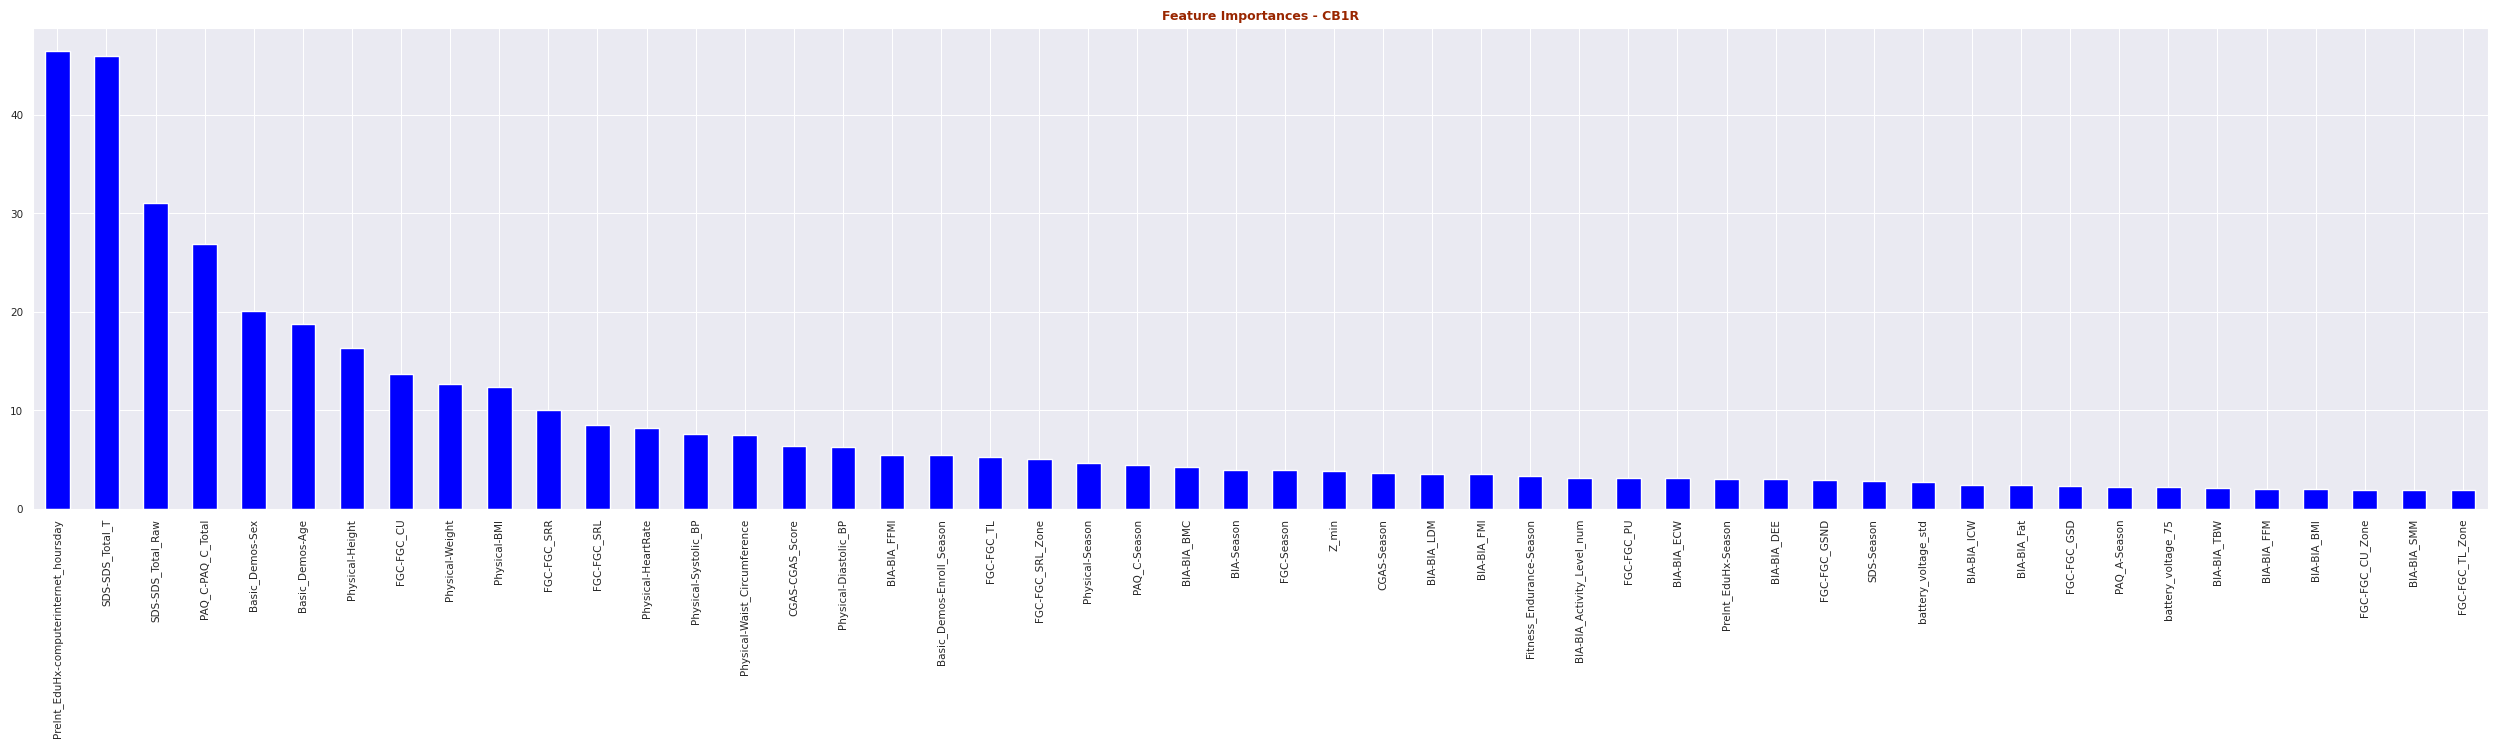



---> 1.576166 +- 0.033724 | OOF
---> 1.320525 +- 0.045537 | Train
---> Max best iteration = 277


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_02 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.535630 | Train = 1.272781 | Iter = 156 
CB1R Fold1           OOF = 1.502550 | Train = 1.316471 | Iter = 130 
CB1R Fold2           OOF = 1.507863 | Train = 1.241435 | Iter = 217 
CB1R Fold3           OOF = 1.520964 | Train = 1.253454 | Iter = 197 
CB1R Fold4           OOF = 1.585864 | Train = 1.304891 | Iter = 113 




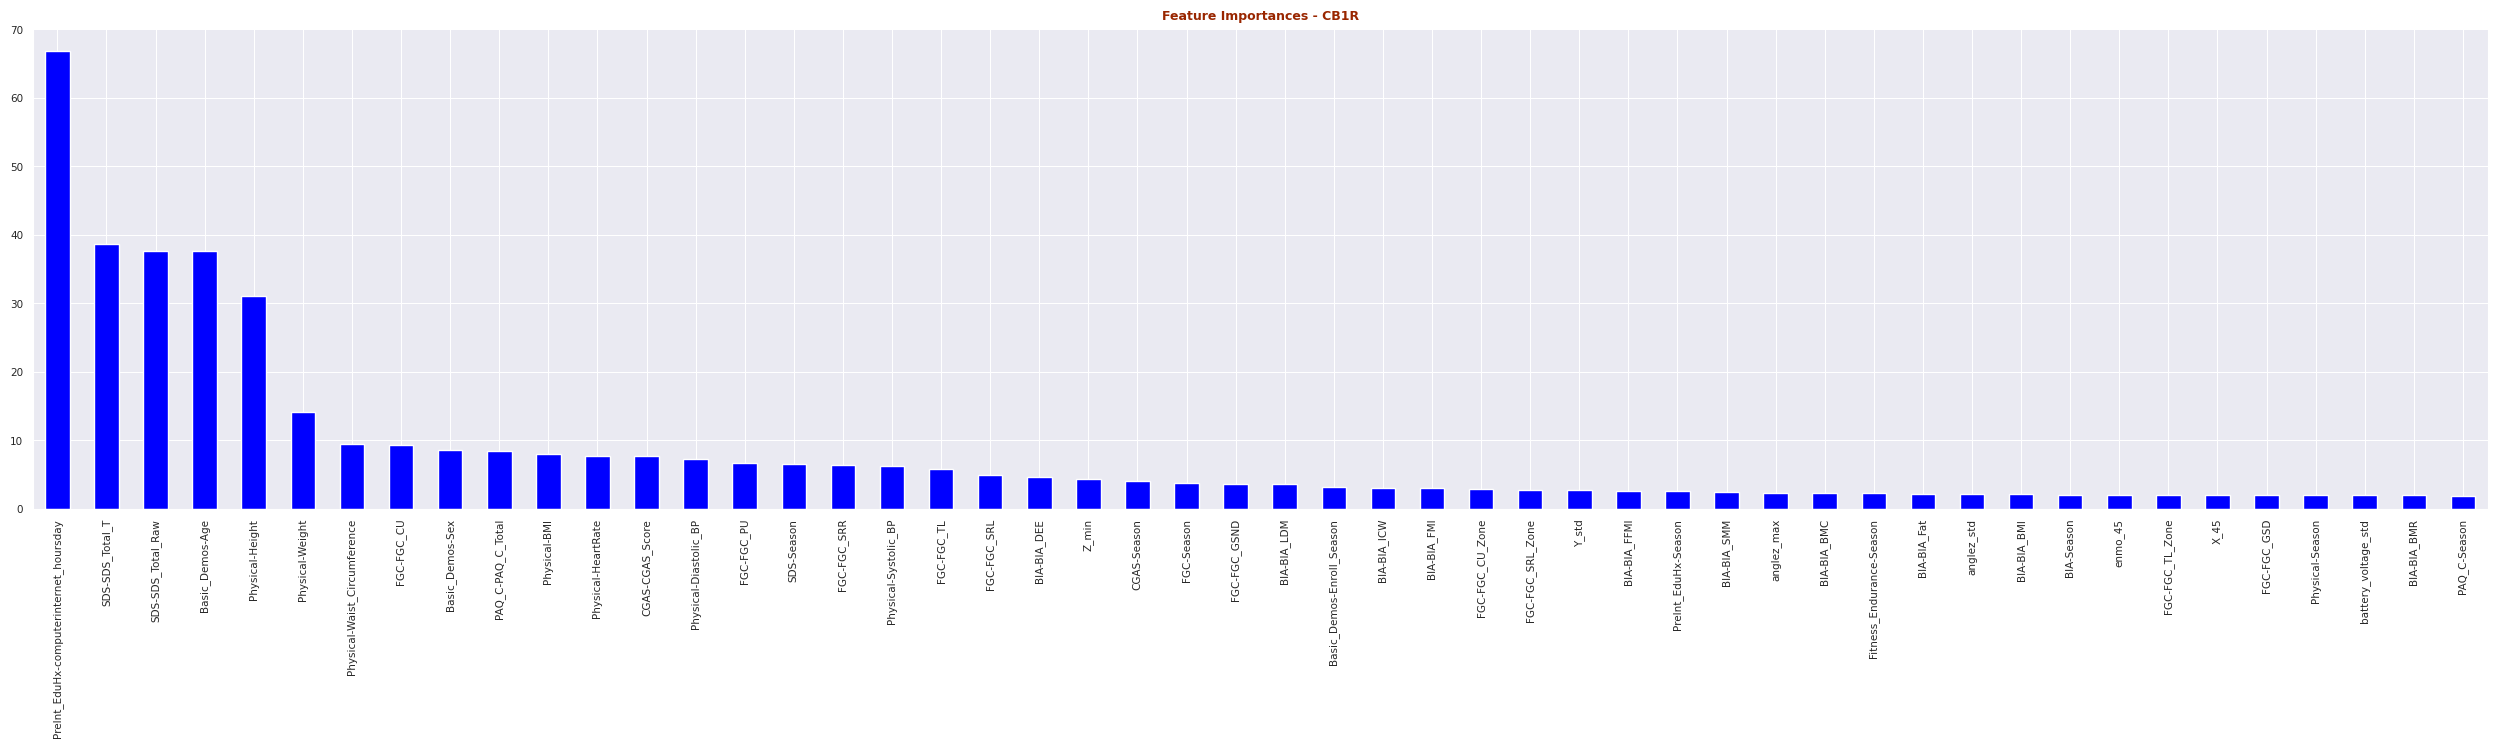



---> 1.530574 +- 0.029920 | OOF
---> 1.277806 +- 0.028878 | Train
---> Max best iteration = 217


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_03 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.440980 | Train = 1.269082 | Iter = 79 
CB1R Fold1           OOF = 1.407006 | Train = 1.183636 | Iter = 179 
CB1R Fold2           OOF = 1.431685 | Train = 1.230295 | Iter = 107 
CB1R Fold3           OOF = 1.401883 | Train = 1.171614 | Iter = 211 
CB1R Fold4           OOF = 1.462141 | Train = 1.193014 | Iter = 135 




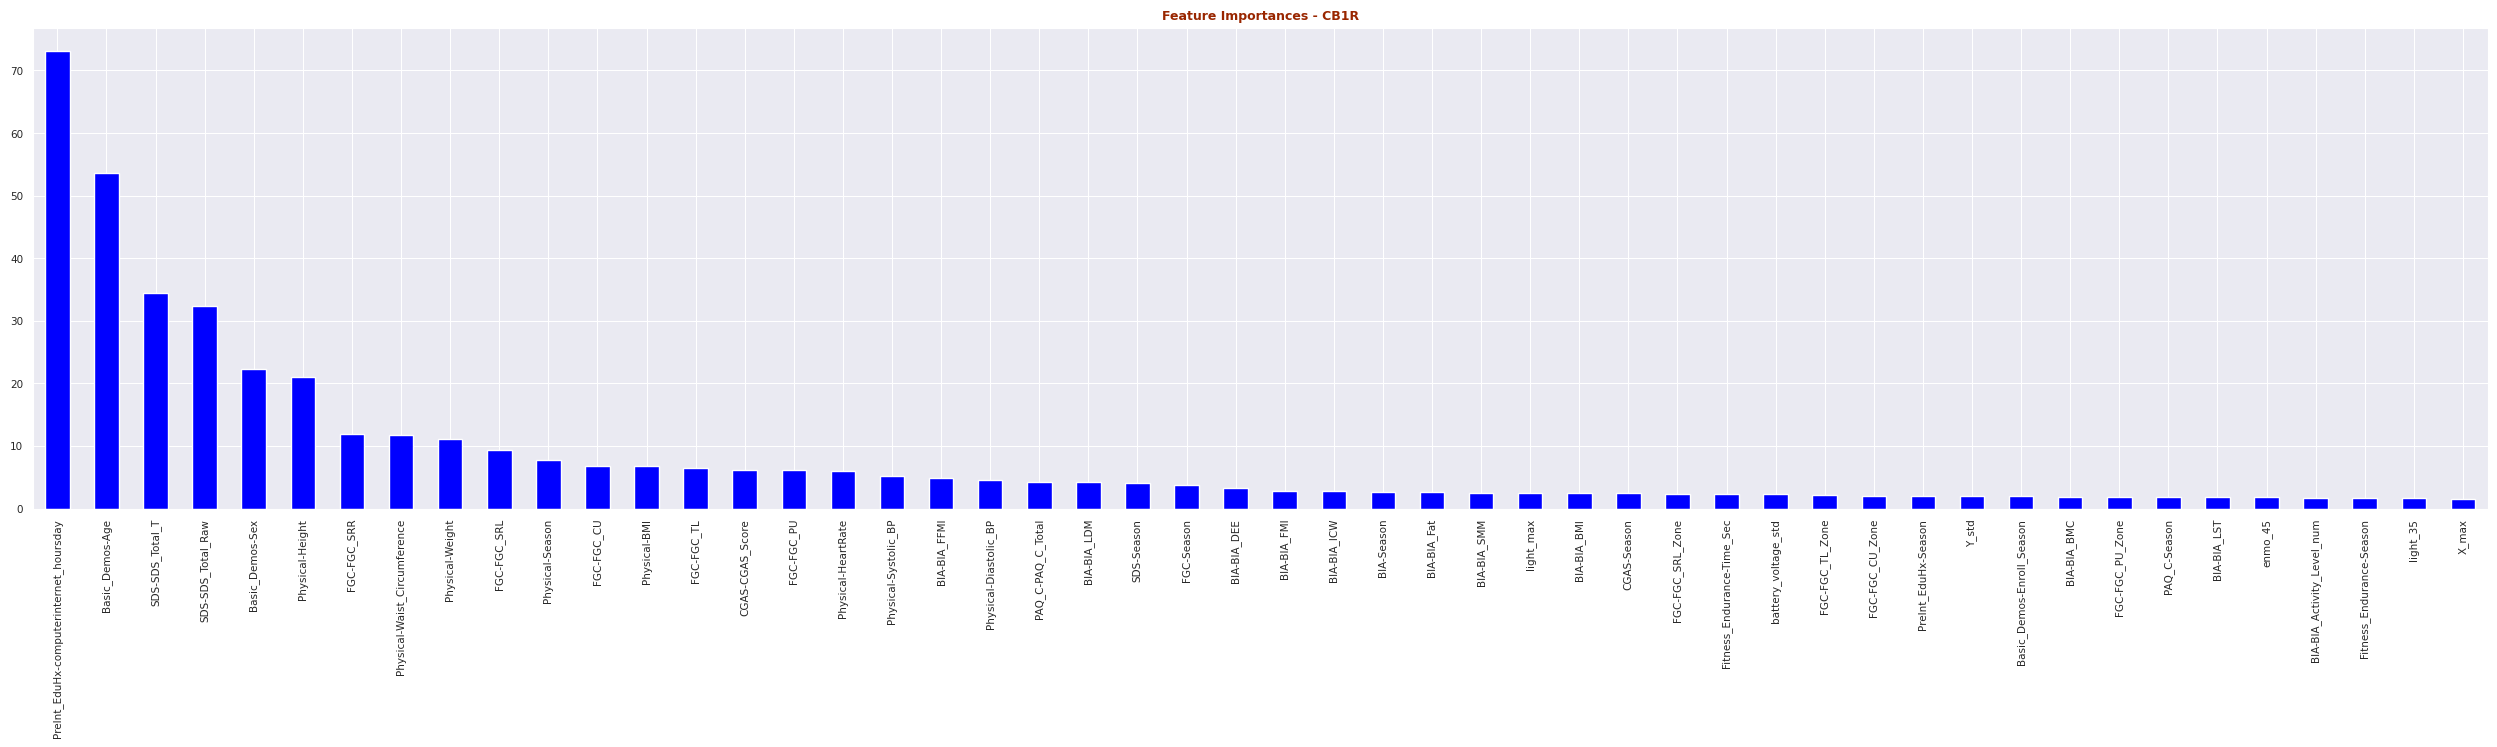



---> 1.428739 +- 0.022216 | OOF
---> 1.209528 +- 0.035661 | Train
---> Max best iteration = 211


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_04 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.061551 | Train = 0.873105 | Iter = 134 
CB1R Fold1           OOF = 0.988819 | Train = 0.891751 | Iter = 139 
CB1R Fold2           OOF = 1.058593 | Train = 0.860004 | Iter = 131 
CB1R Fold3           OOF = 1.073898 | Train = 0.876669 | Iter = 127 
CB1R Fold4           OOF = 1.104594 | Train = 0.893143 | Iter = 90 




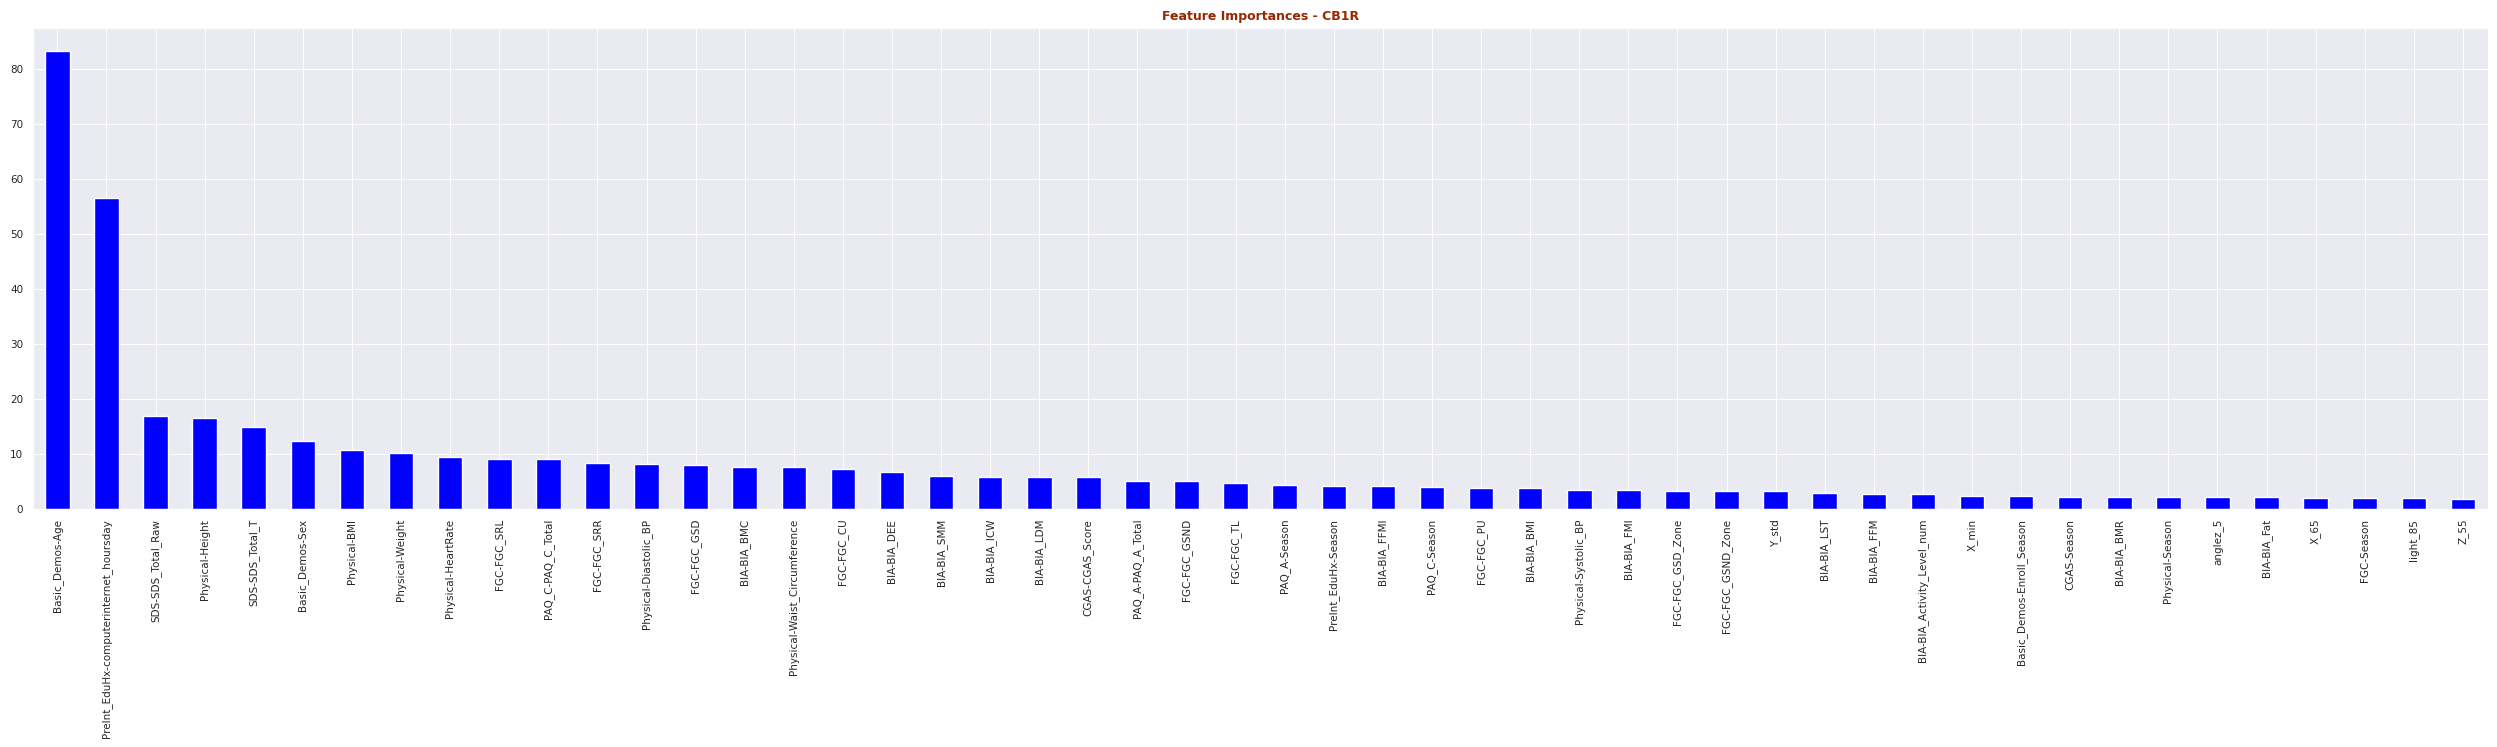



---> 1.057491 +- 0.038004 | OOF
---> 0.878934 +- 0.012358 | Train
---> Max best iteration = 139


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_05 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.529926 | Train = 1.328761 | Iter = 112 
CB1R Fold1           OOF = 1.510522 | Train = 1.255583 | Iter = 191 
CB1R Fold2           OOF = 1.557386 | Train = 1.255840 | Iter = 173 
CB1R Fold3           OOF = 1.491946 | Train = 1.320273 | Iter = 131 
CB1R Fold4           OOF = 1.569475 | Train = 1.321621 | Iter = 105 




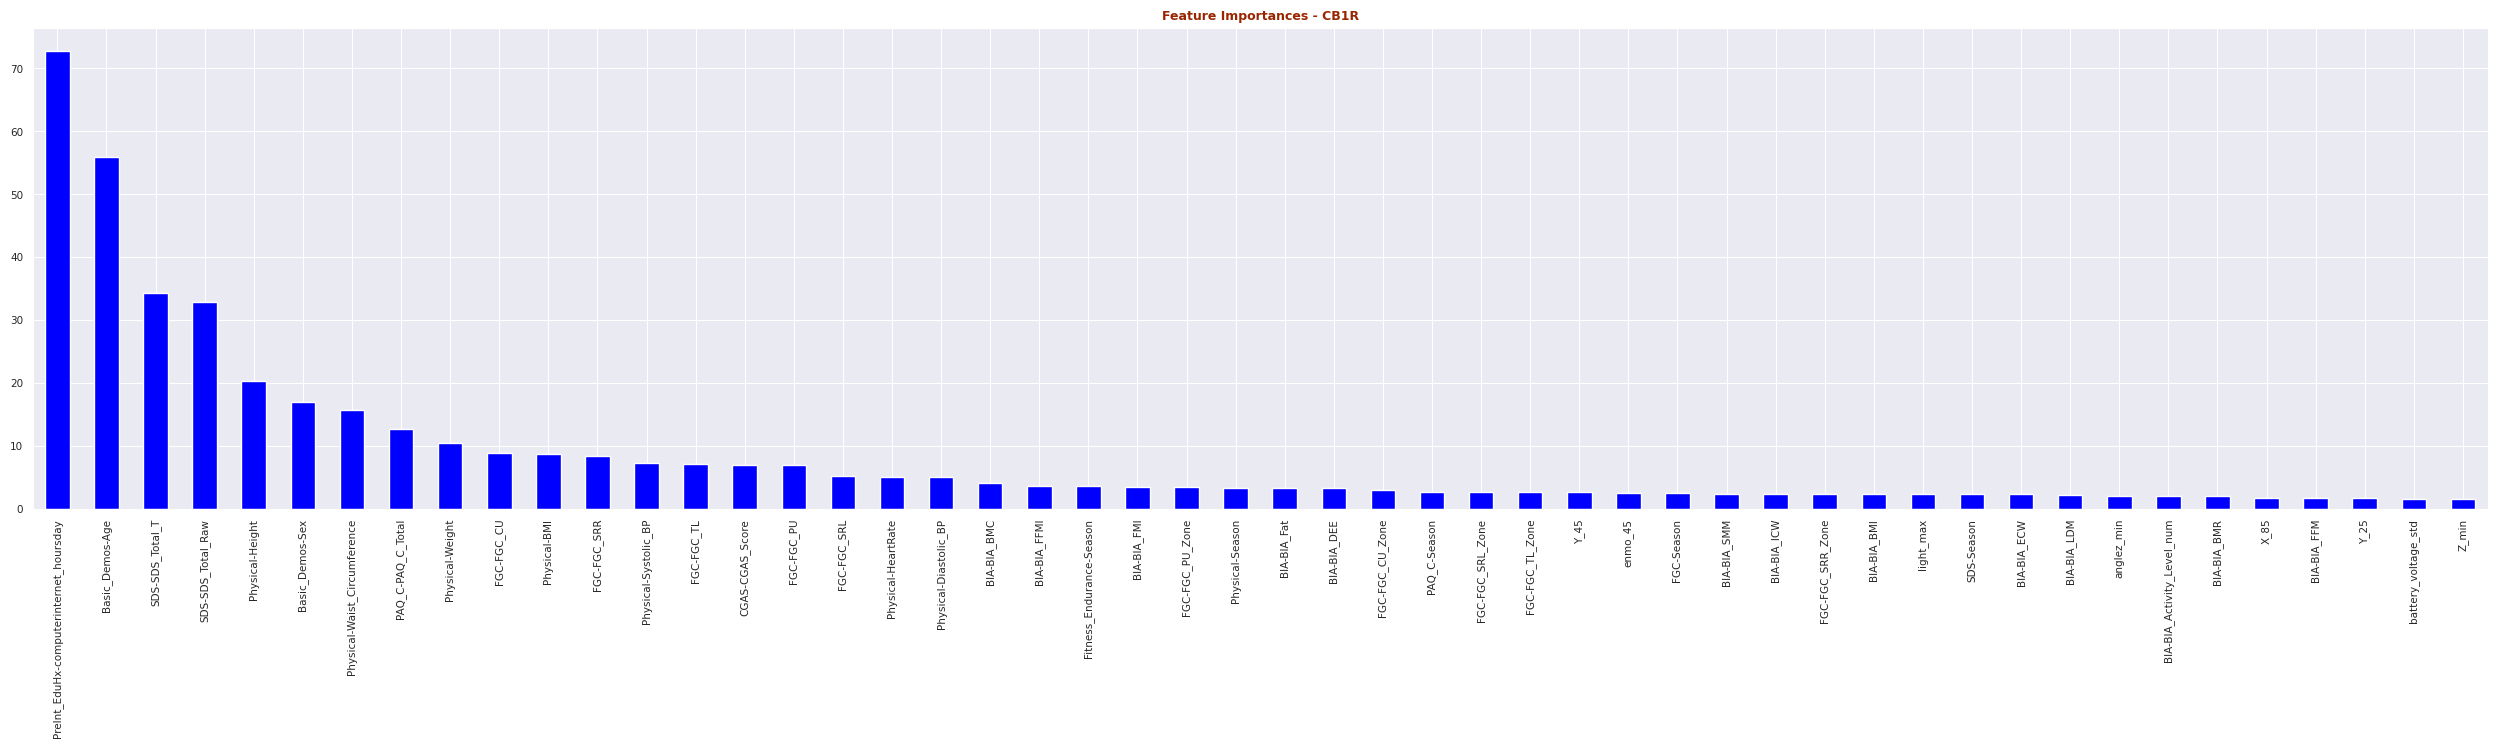



---> 1.531851 +- 0.028701 | OOF
---> 1.296416 +- 0.033360 | Train
---> Max best iteration = 191


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_06 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.156846 | Train = 0.957229 | Iter = 68 
CB1R Fold1           OOF = 1.009501 | Train = 0.877720 | Iter = 167 
CB1R Fold2           OOF = 1.120059 | Train = 0.901522 | Iter = 124 
CB1R Fold3           OOF = 1.133050 | Train = 0.902494 | Iter = 132 
CB1R Fold4           OOF = 1.071706 | Train = 0.917521 | Iter = 117 




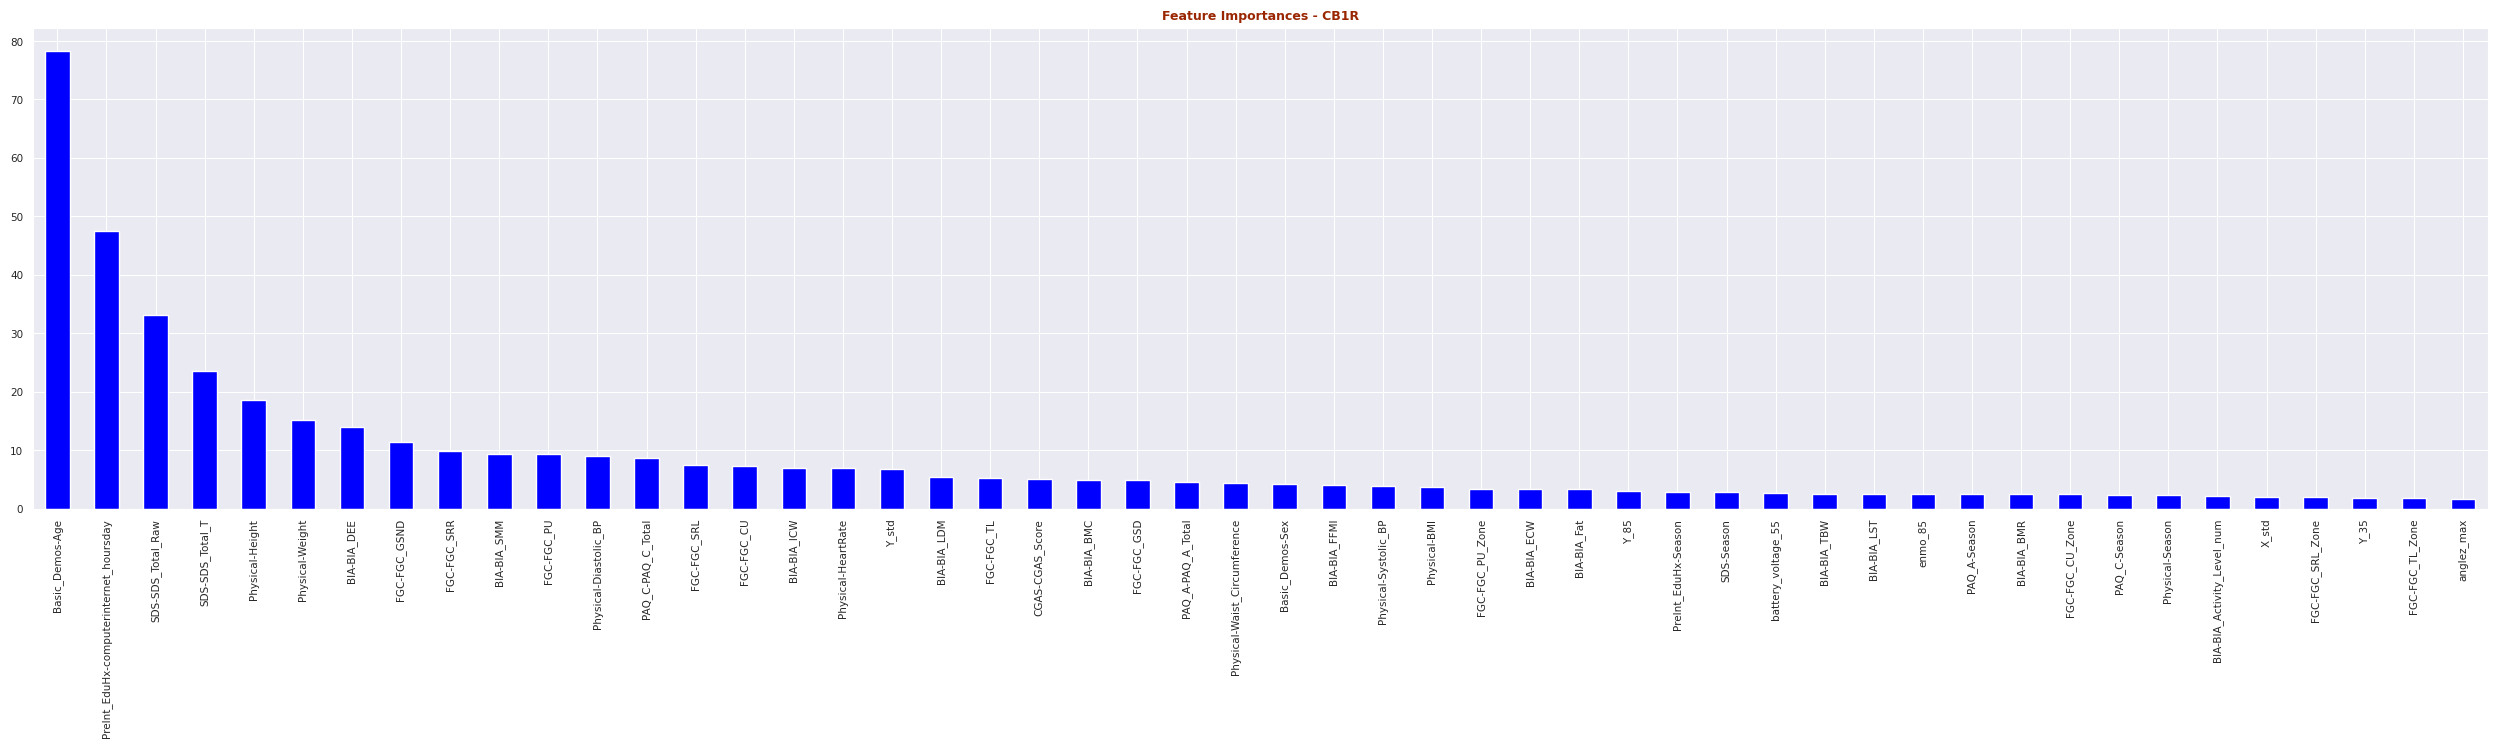



---> 1.098232 +- 0.052347 | OOF
---> 0.911297 +- 0.026264 | Train
---> Max best iteration = 167


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_07 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 0.926013 | Train = 0.678917 | Iter = 122 
CB1R Fold1           OOF = 0.868580 | Train = 0.738929 | Iter = 82 
CB1R Fold2           OOF = 0.868897 | Train = 0.677654 | Iter = 160 
CB1R Fold3           OOF = 0.817057 | Train = 0.717344 | Iter = 119 
CB1R Fold4           OOF = 0.819968 | Train = 0.721689 | Iter = 106 




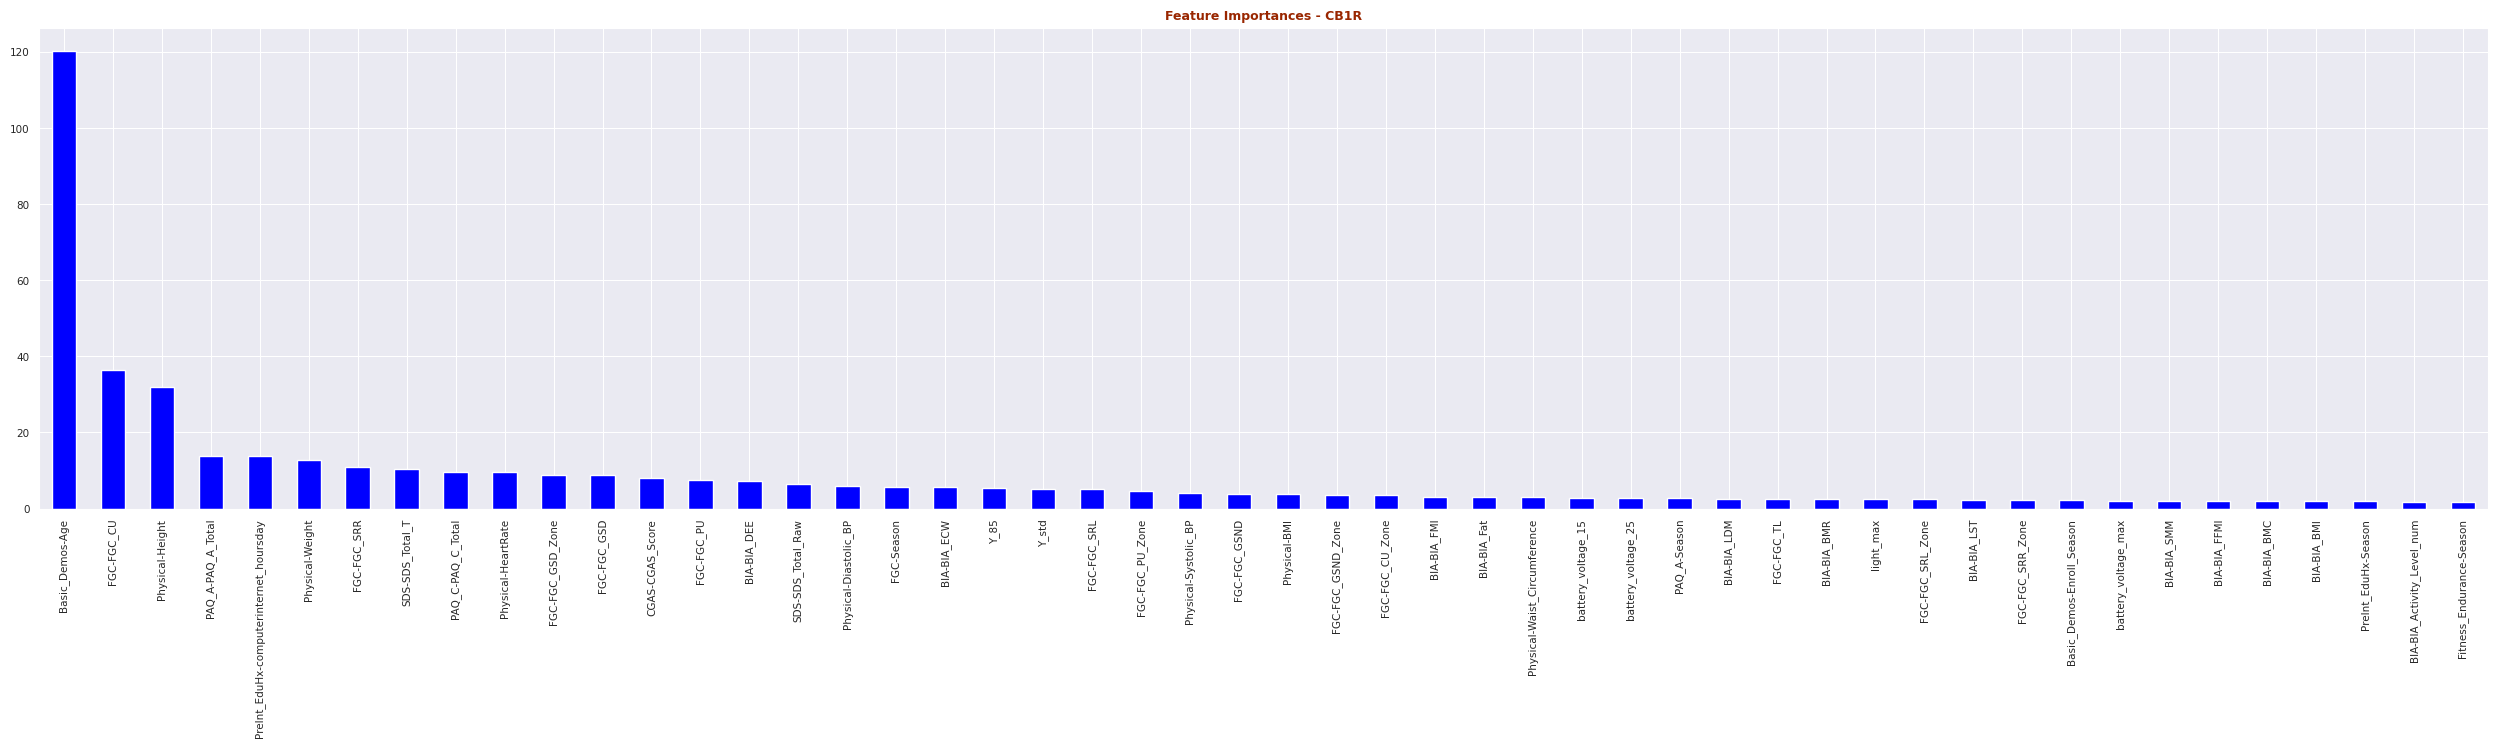



---> 0.860103 +- 0.039893 | OOF
---> 0.706907 +- 0.024462 | Train
---> Max best iteration = 160


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_08 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.238033 | Train = 1.033285 | Iter = 124 
CB1R Fold1           OOF = 1.224906 | Train = 1.056324 | Iter = 92 
CB1R Fold2           OOF = 1.201324 | Train = 1.033284 | Iter = 126 
CB1R Fold3           OOF = 1.226535 | Train = 1.017089 | Iter = 140 
CB1R Fold4           OOF = 1.142021 | Train = 1.002200 | Iter = 188 




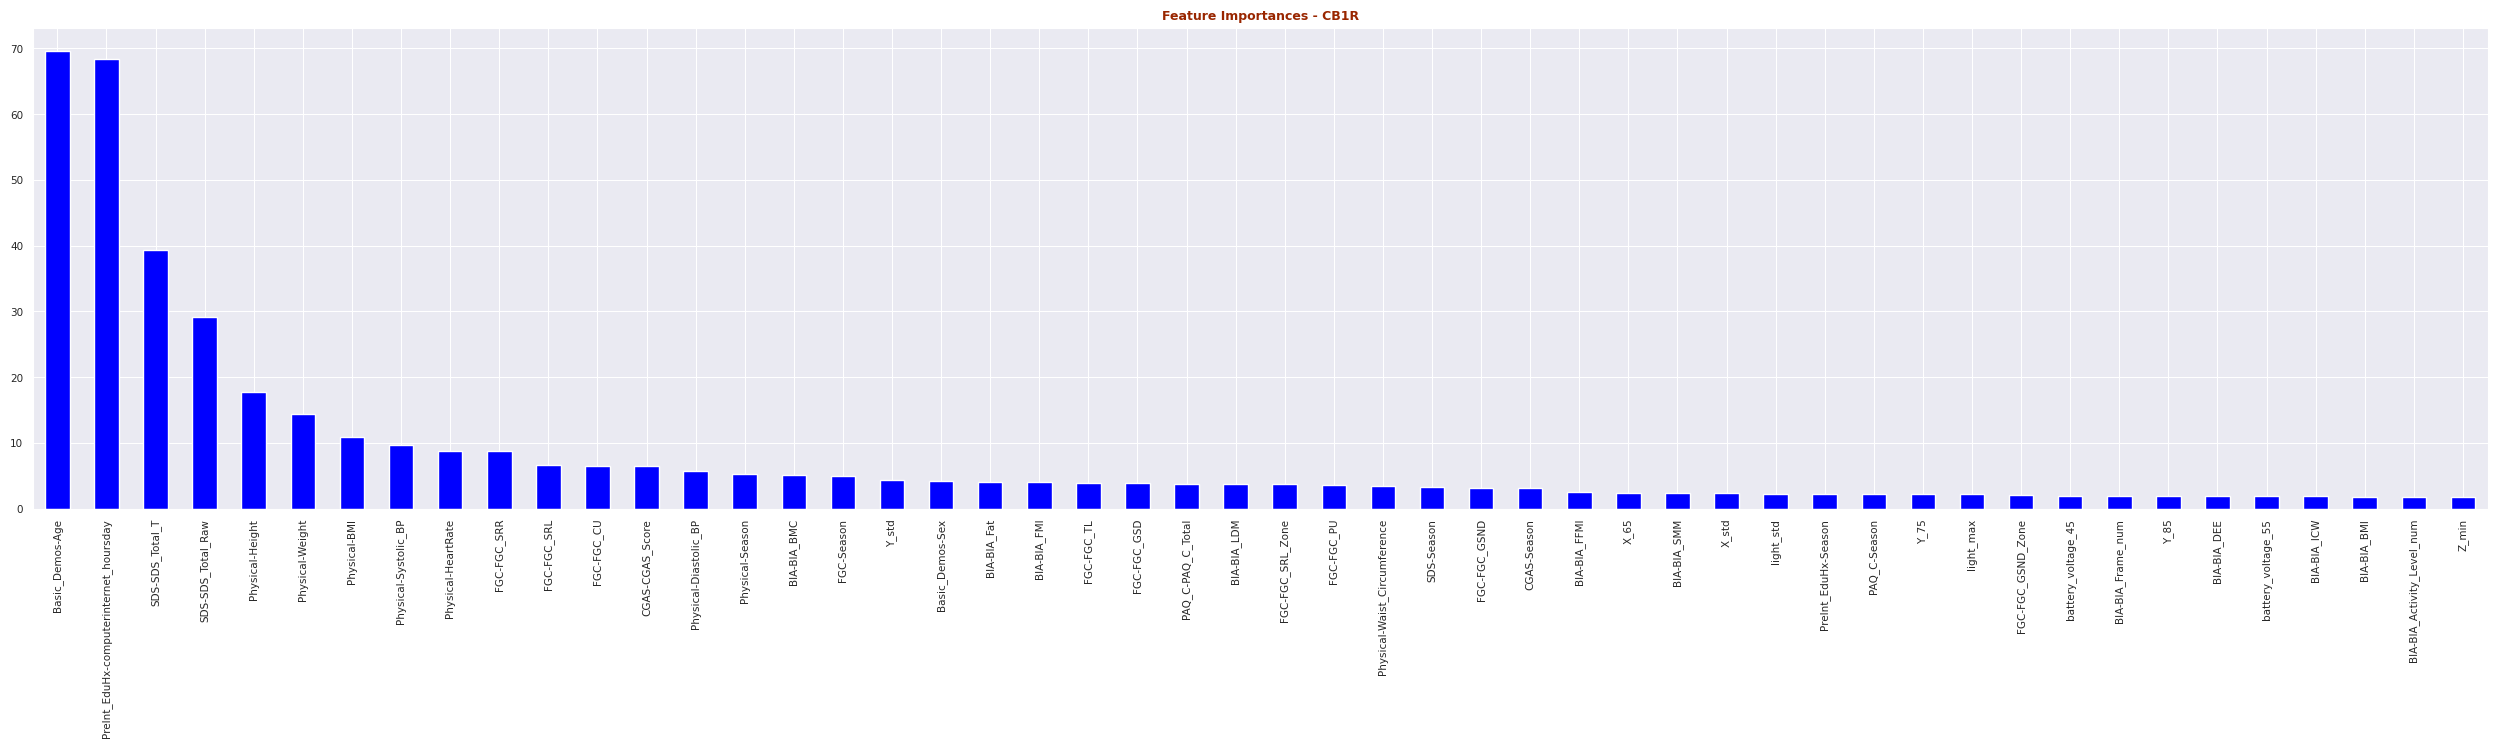



---> 1.206564 +- 0.034406 | OOF
---> 1.028437 +- 0.018121 | Train
---> Max best iteration = 188


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_09 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.112312 | Train = 0.897516 | Iter = 188 
CB1R Fold1           OOF = 1.070258 | Train = 0.943921 | Iter = 120 
CB1R Fold2           OOF = 1.094886 | Train = 0.876256 | Iter = 219 
CB1R Fold3           OOF = 1.131262 | Train = 0.911991 | Iter = 174 
CB1R Fold4           OOF = 1.122574 | Train = 0.969933 | Iter = 81 




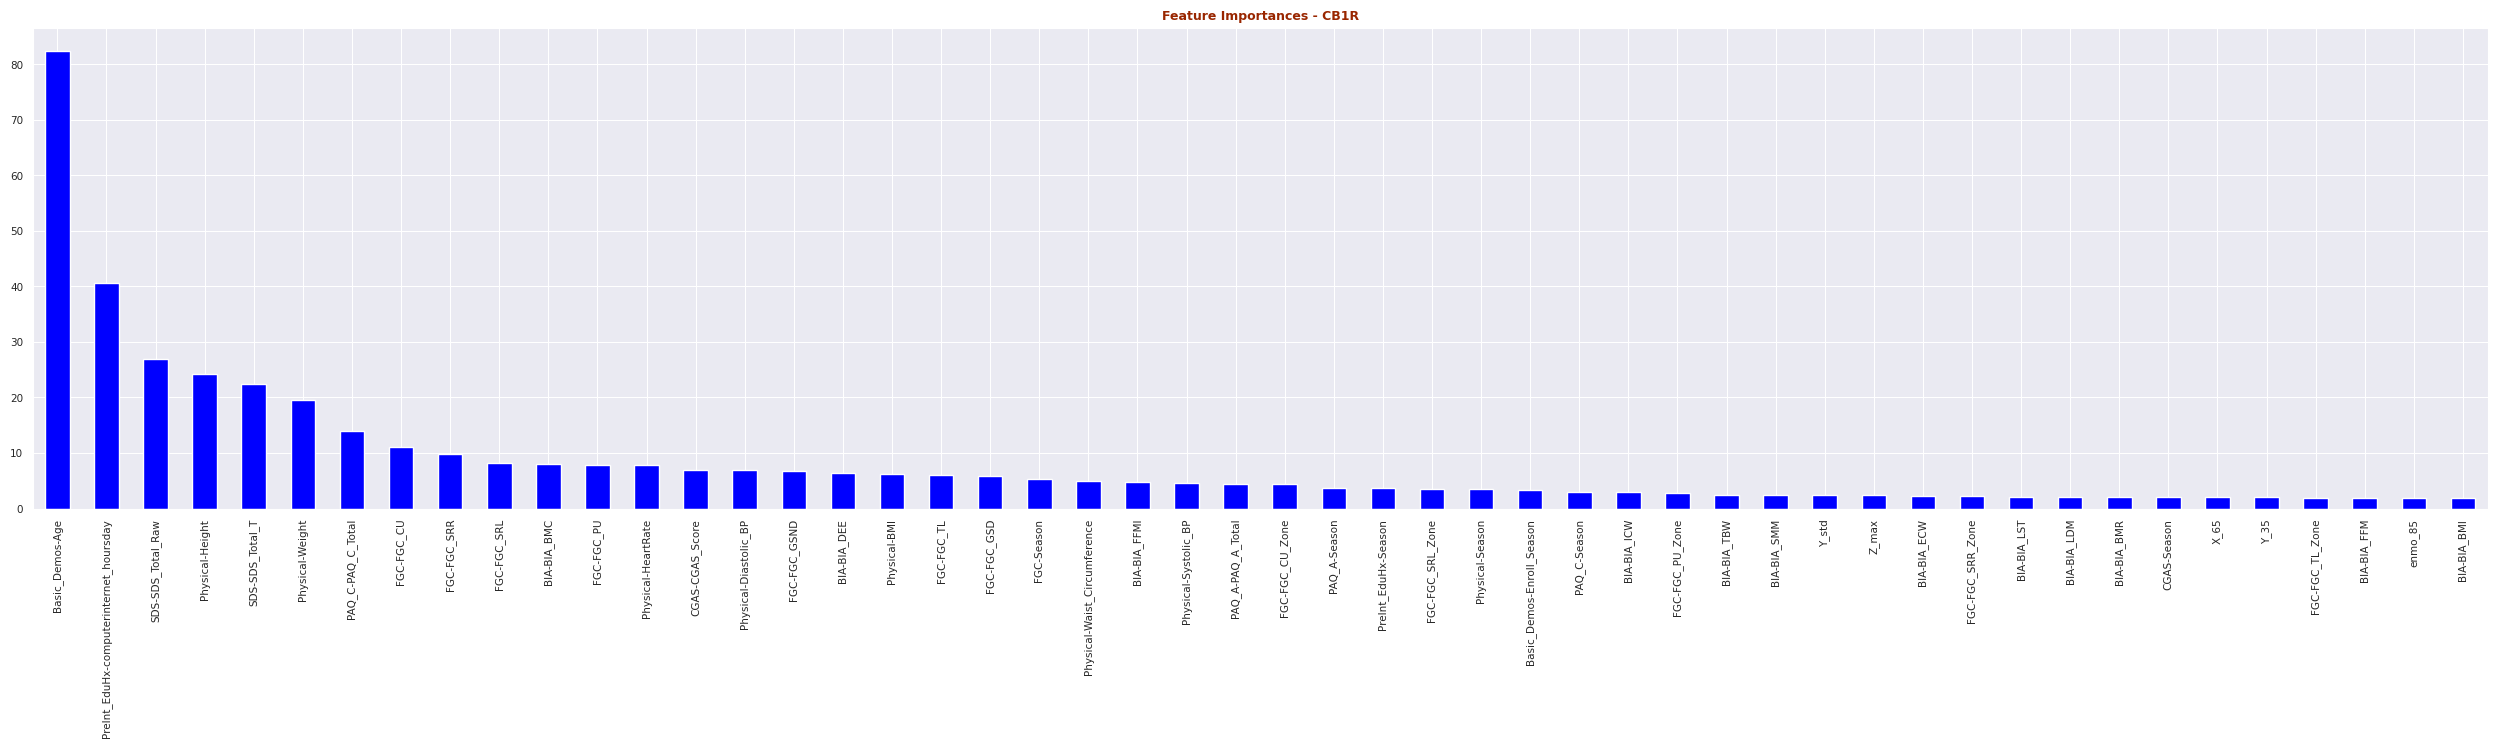



---> 1.106258 +- 0.021695 | OOF
---> 0.919923 +- 0.033313 | Train
---> Max best iteration = 219


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_10 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.210505 | Train = 1.078598 | Iter = 92 
CB1R Fold1           OOF = 1.204487 | Train = 1.029938 | Iter = 148 
CB1R Fold2           OOF = 1.227172 | Train = 1.039778 | Iter = 125 
CB1R Fold3           OOF = 1.244998 | Train = 1.015052 | Iter = 168 
CB1R Fold4           OOF = 1.278248 | Train = 0.979175 | Iter = 196 




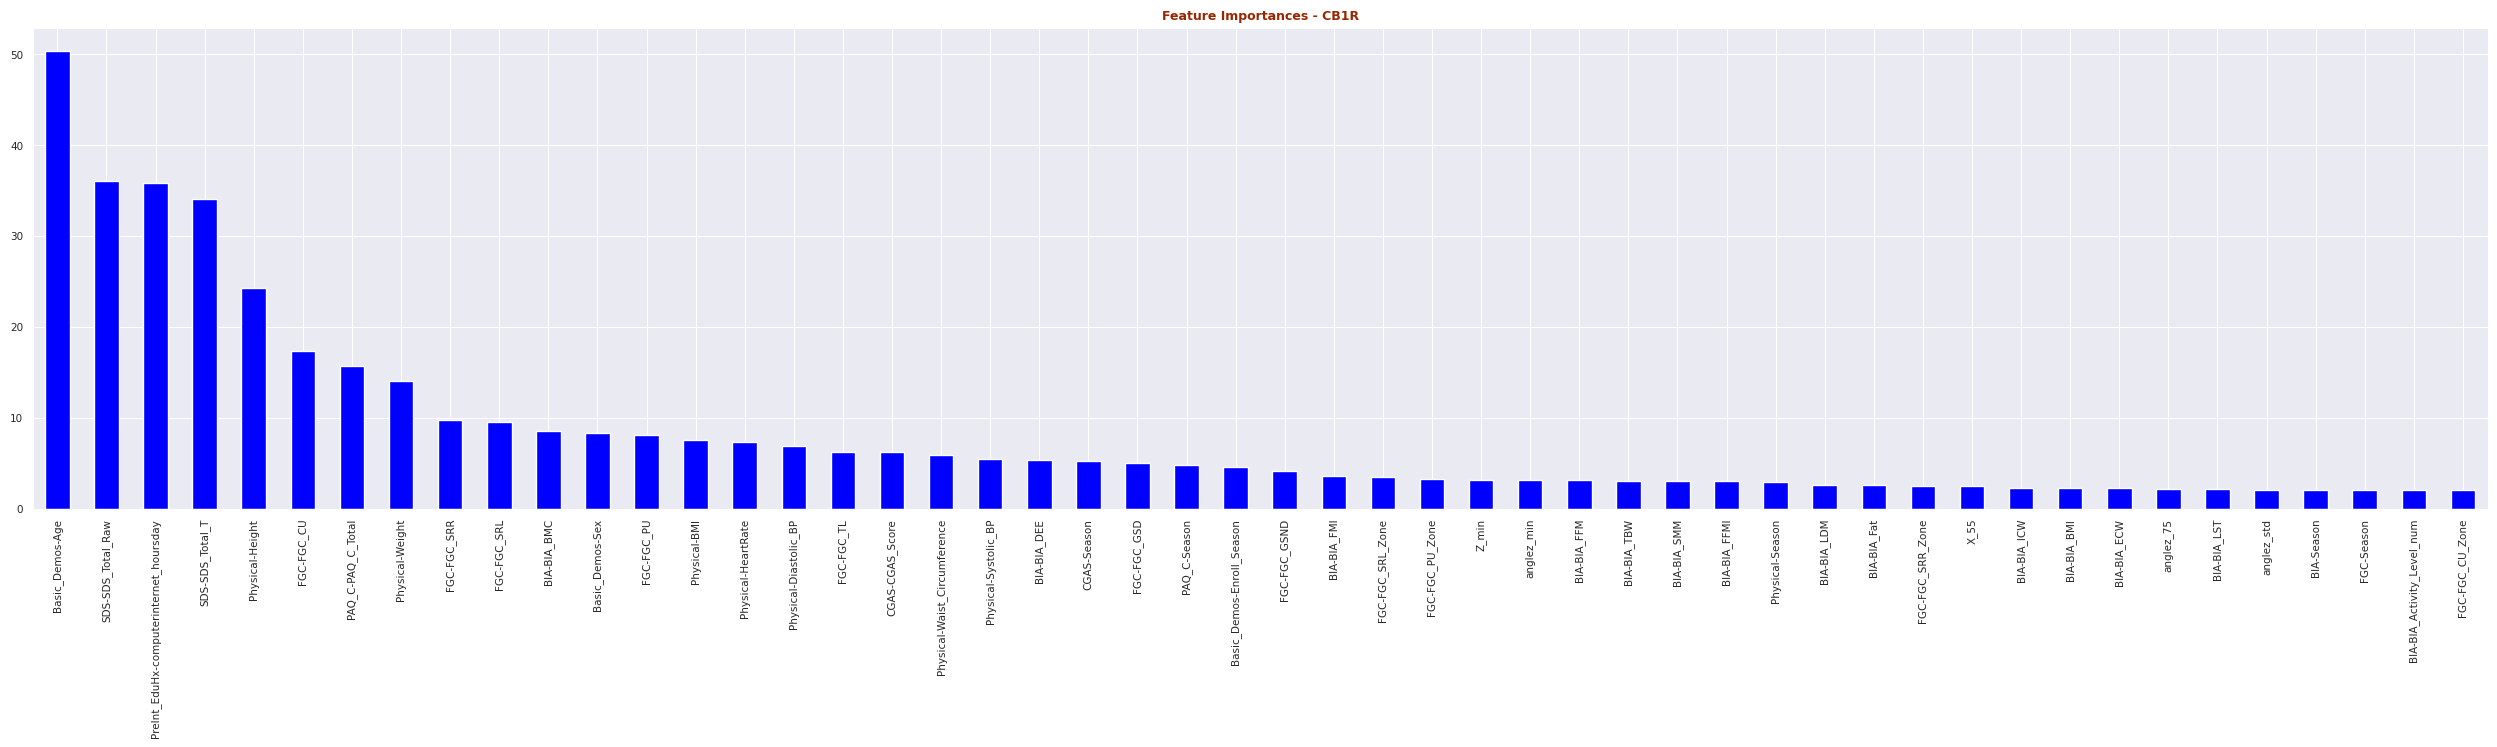



---> 1.233082 +- 0.026624 | OOF
---> 1.028508 +- 0.032413 | Train
---> Max best iteration = 196


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_11 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.397283 | Train = 1.144479 | Iter = 87 
CB1R Fold1           OOF = 1.264913 | Train = 1.164446 | Iter = 109 
CB1R Fold2           OOF = 1.361726 | Train = 1.138559 | Iter = 111 
CB1R Fold3           OOF = 1.299222 | Train = 1.062920 | Iter = 251 
CB1R Fold4           OOF = 1.340814 | Train = 1.158631 | Iter = 107 




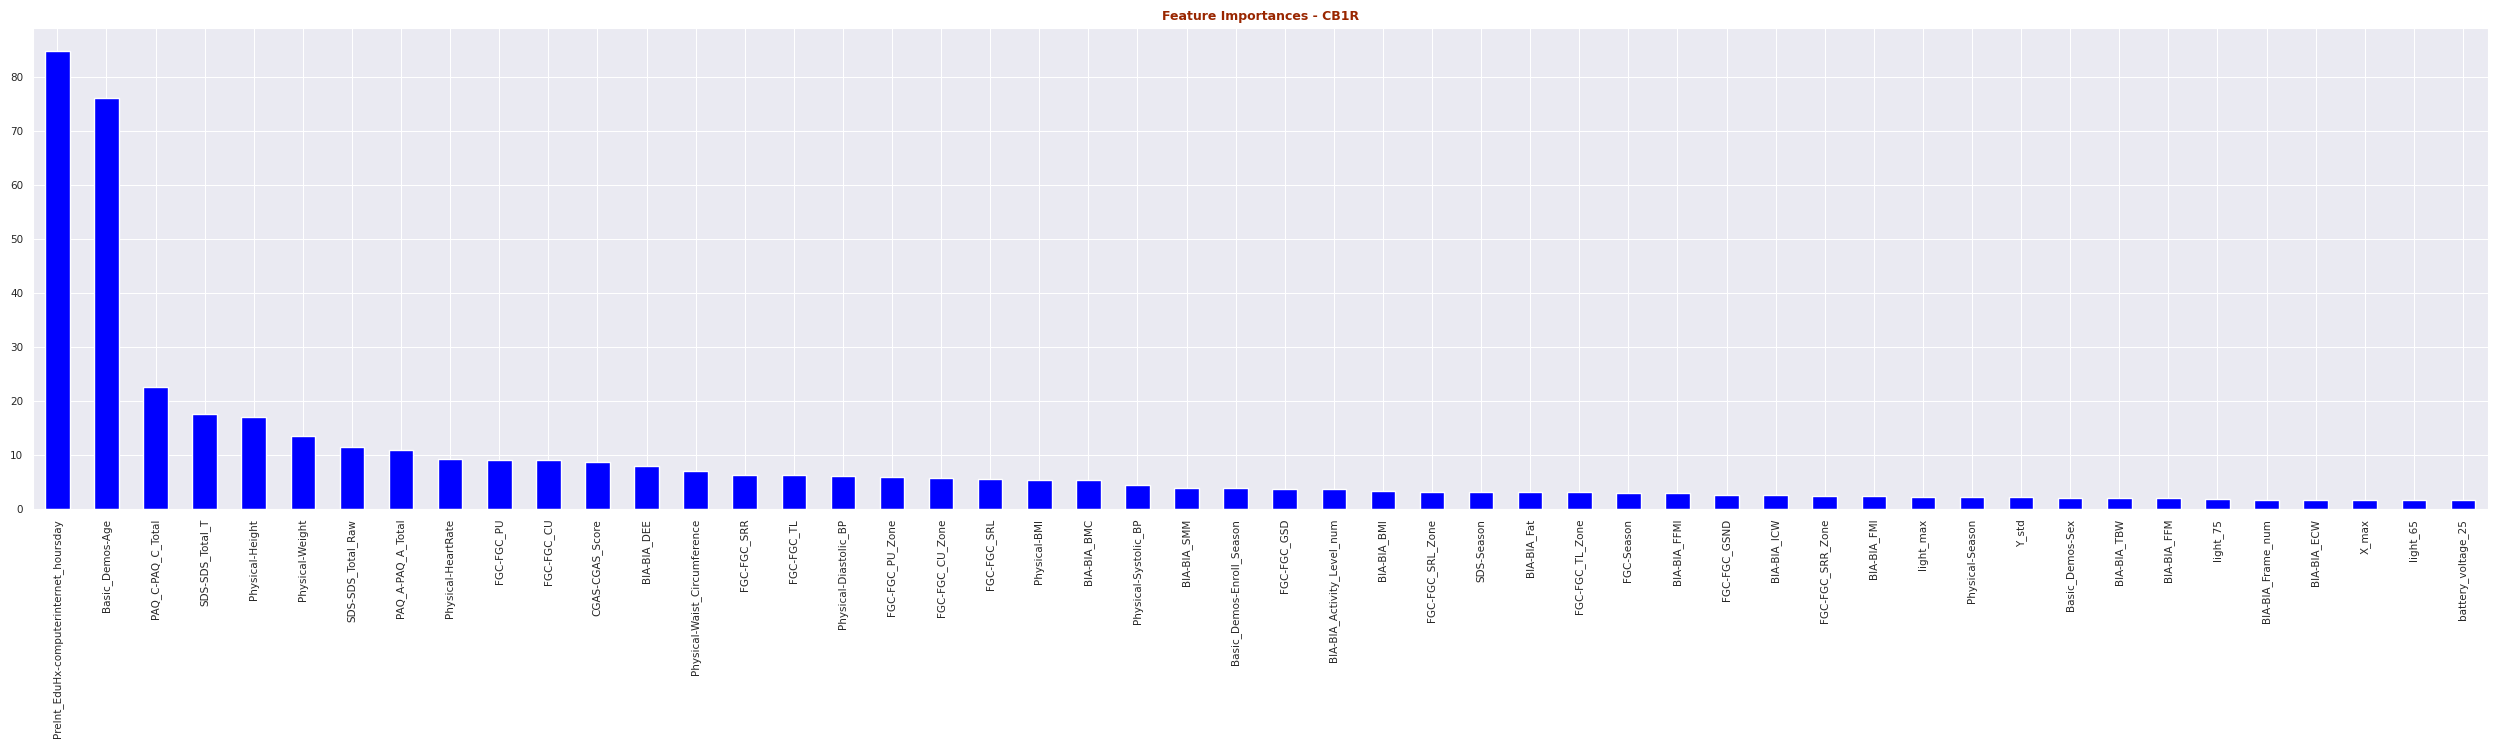



---> 1.332792 +- 0.046465 | OOF
---> 1.133807 +- 0.036651 | Train
---> Max best iteration = 251


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_12 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 0.396696 | Train = 0.463554 | Iter = 39 
CB1R Fold1           OOF = 0.516502 | Train = 0.395622 | Iter = 90 
CB1R Fold2           OOF = 0.507119 | Train = 0.420323 | Iter = 59 
CB1R Fold3           OOF = 0.465309 | Train = 0.392849 | Iter = 106 
CB1R Fold4           OOF = 0.541734 | Train = 0.379274 | Iter = 109 




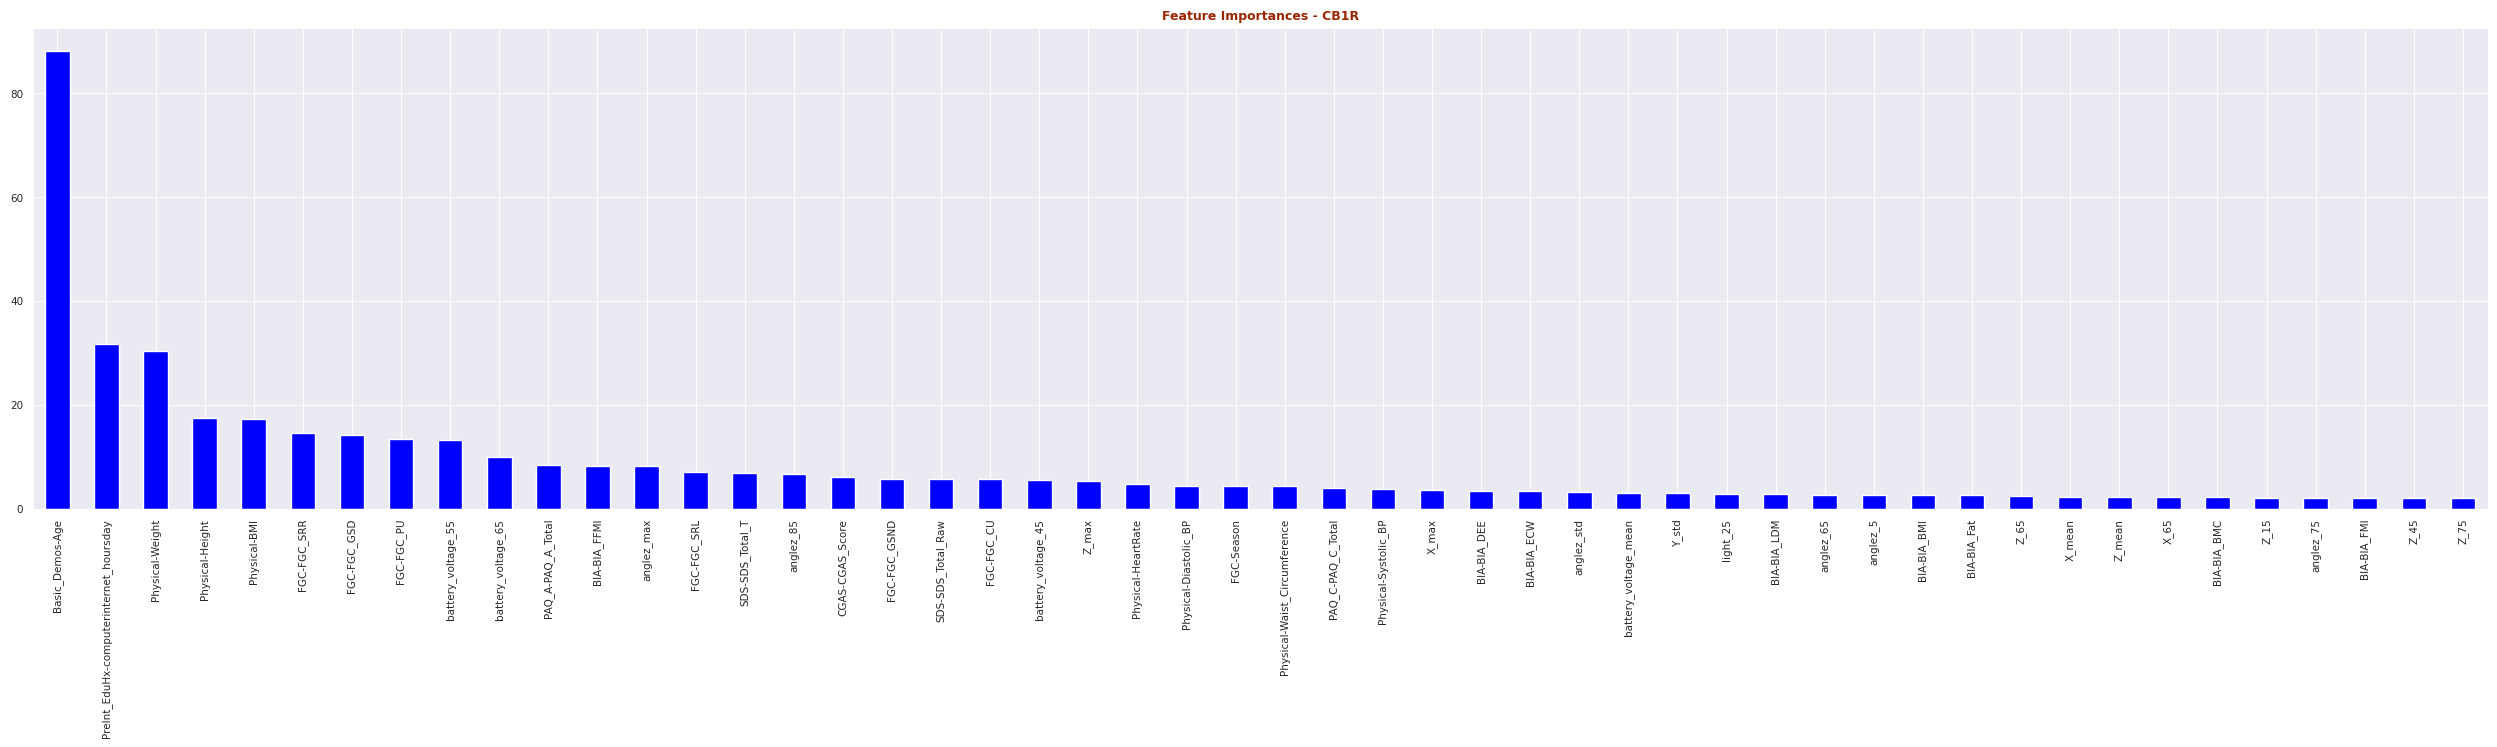



---> 0.485472 +- 0.050763 | OOF
---> 0.410324 +- 0.029729 | Train
---> Max best iteration = 109


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_13 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.364495 | Train = 1.106389 | Iter = 149 
CB1R Fold1           OOF = 1.318655 | Train = 1.129625 | Iter = 128 
CB1R Fold2           OOF = 1.268779 | Train = 1.096876 | Iter = 160 
CB1R Fold3           OOF = 1.272428 | Train = 1.089990 | Iter = 198 
CB1R Fold4           OOF = 1.354437 | Train = 1.115653 | Iter = 118 




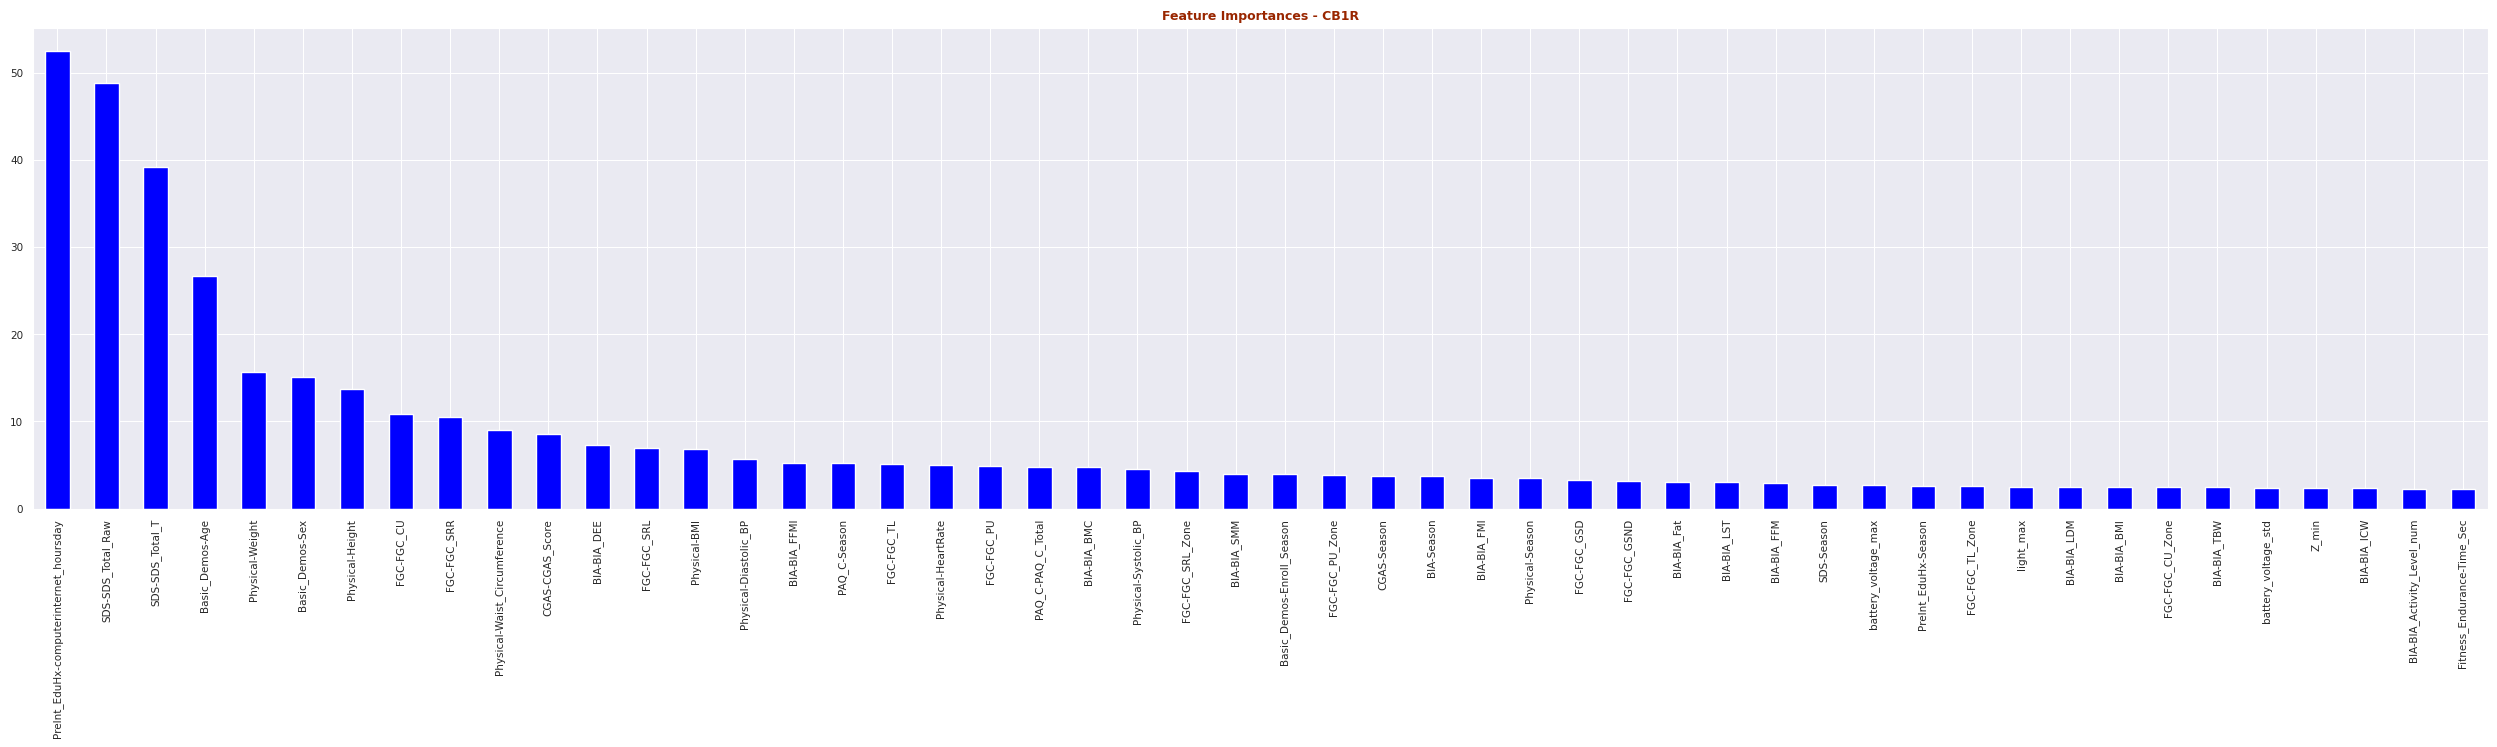



---> 1.315759 +- 0.039911 | OOF
---> 1.107707 +- 0.013975 | Train
---> Max best iteration = 198


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_14 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.220459 | Train = 0.889180 | Iter = 256 
CB1R Fold1           OOF = 1.138493 | Train = 0.997102 | Iter = 104 
CB1R Fold2           OOF = 1.141799 | Train = 0.995150 | Iter = 95 
CB1R Fold3           OOF = 1.160377 | Train = 1.007034 | Iter = 92 
CB1R Fold4           OOF = 1.158849 | Train = 0.950681 | Iter = 168 




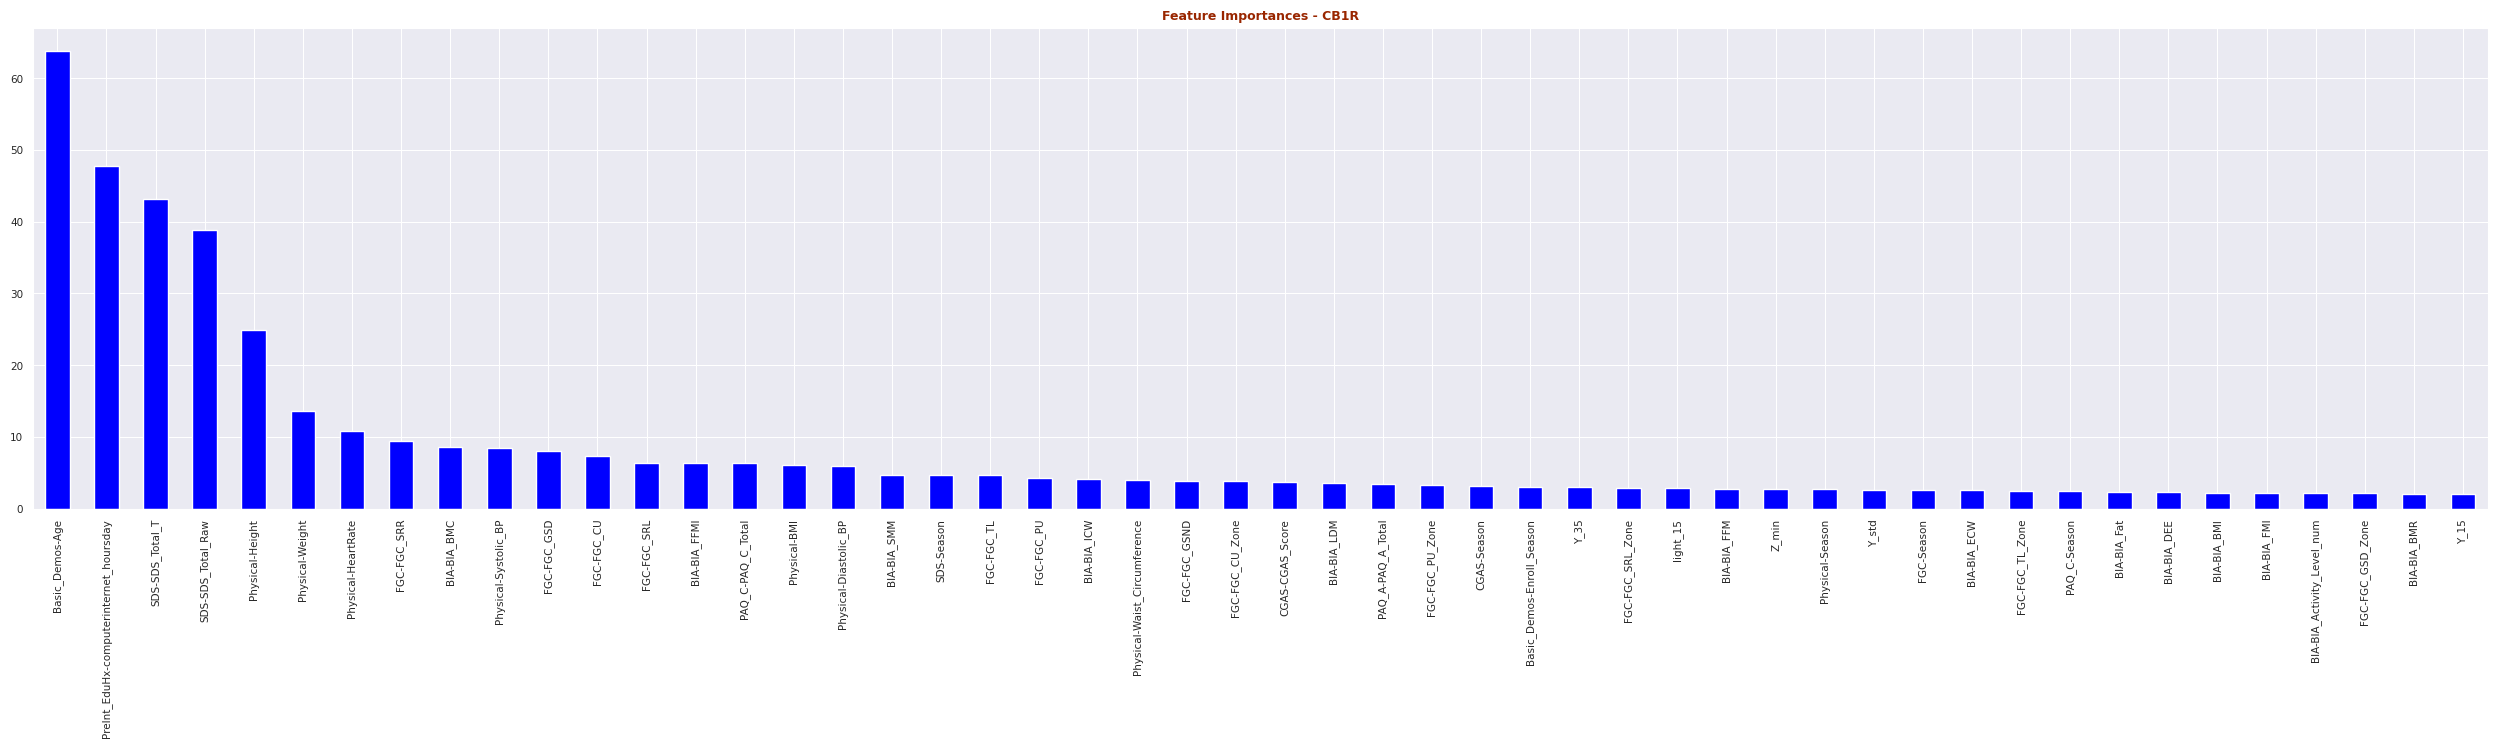



---> 1.163995 +- 0.029566 | OOF
---> 0.967829 +- 0.043864 | Train
---> Max best iteration = 256


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_15 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.378152 | Train = 1.147116 | Iter = 116 
CB1R Fold1           OOF = 1.347214 | Train = 1.148418 | Iter = 134 
CB1R Fold2           OOF = 1.322277 | Train = 1.126708 | Iter = 142 
CB1R Fold3           OOF = 1.365539 | Train = 1.175775 | Iter = 96 
CB1R Fold4           OOF = 1.364823 | Train = 1.164703 | Iter = 121 




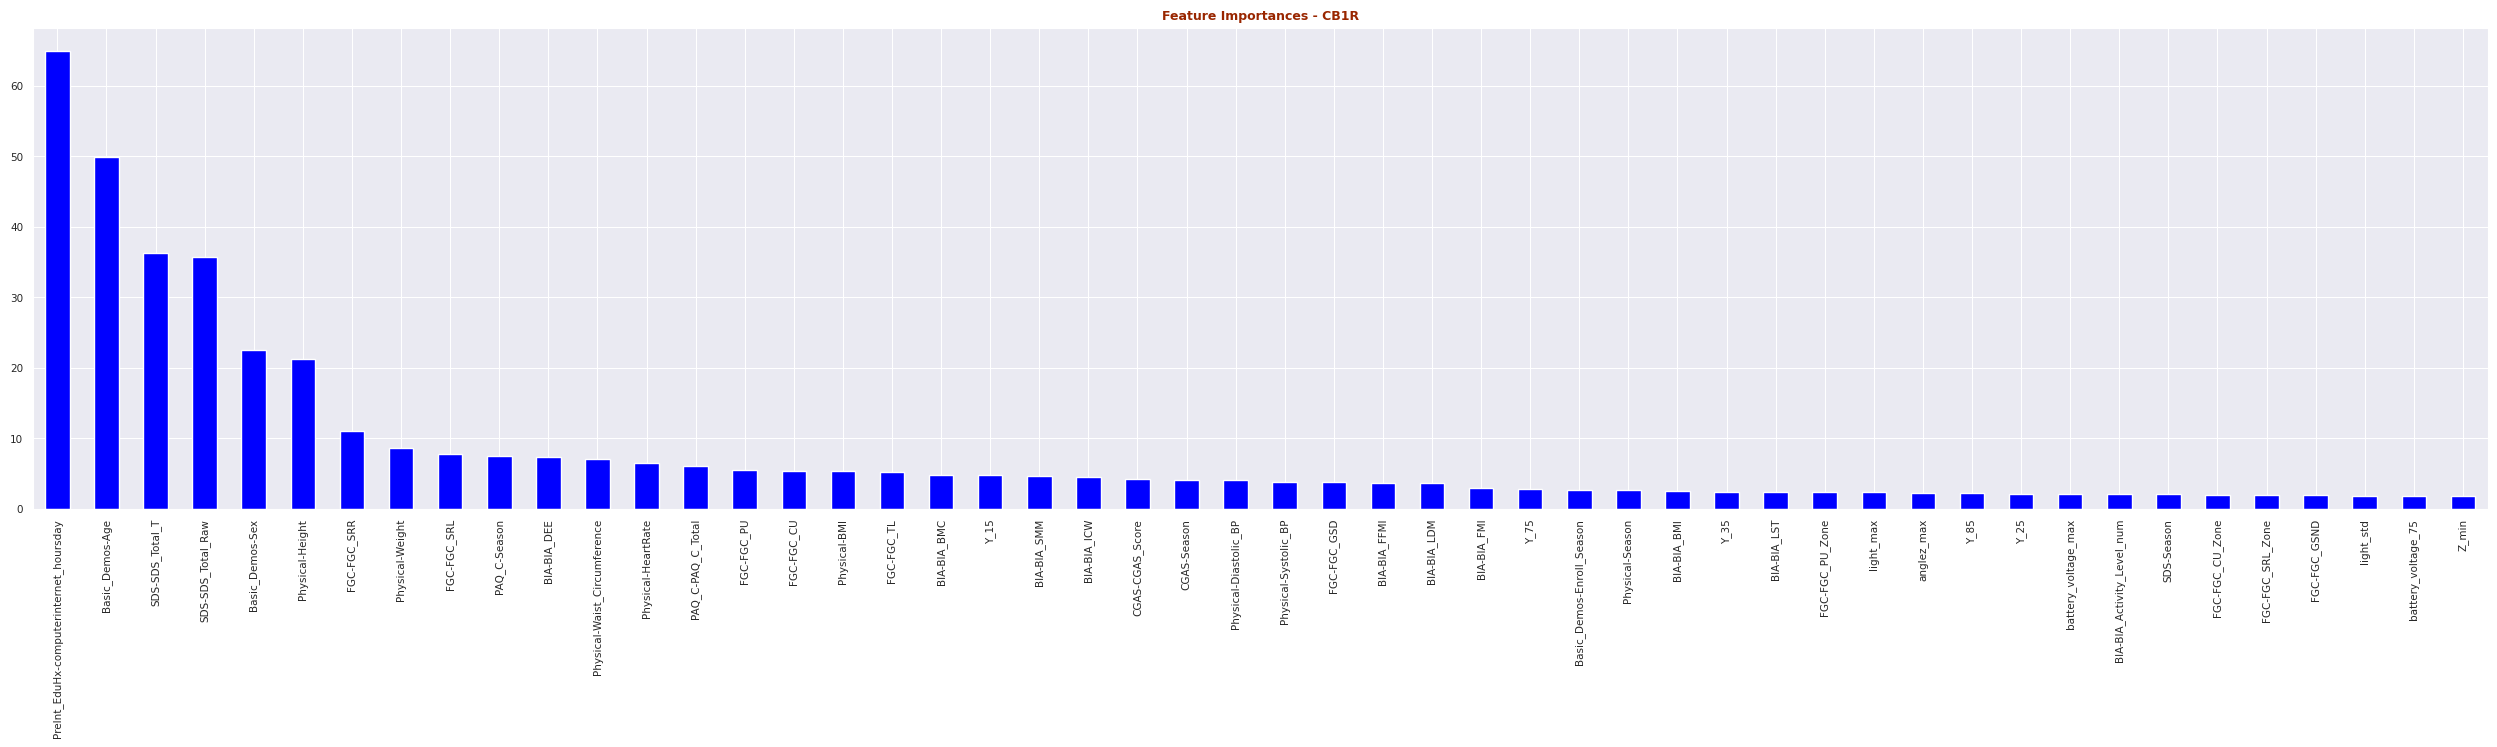



---> 1.355601 +- 0.019355 | OOF
---> 1.152544 +- 0.016742 | Train
---> Max best iteration = 142


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_16 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.431774 | Train = 1.229830 | Iter = 116 
CB1R Fold1           OOF = 1.392852 | Train = 1.258218 | Iter = 95 
CB1R Fold2           OOF = 1.389577 | Train = 1.291094 | Iter = 71 
CB1R Fold3           OOF = 1.408618 | Train = 1.175133 | Iter = 202 
CB1R Fold4           OOF = 1.456814 | Train = 1.224761 | Iter = 104 




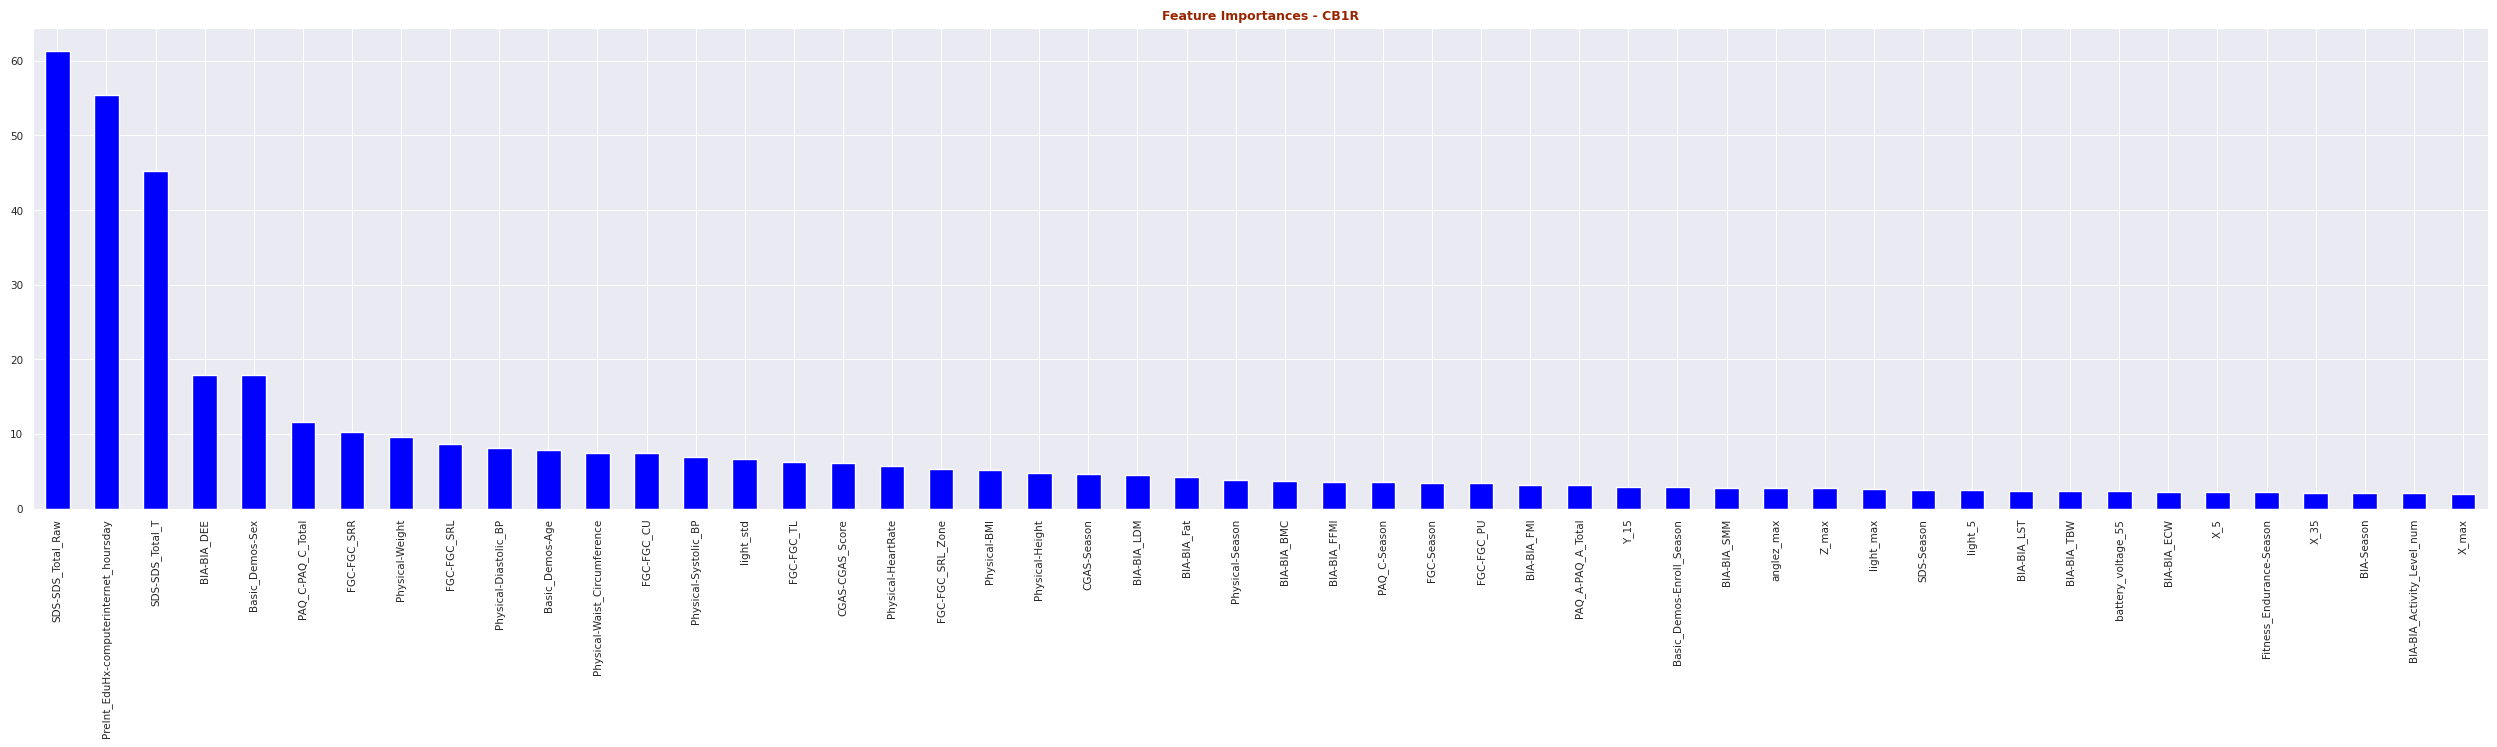



---> 1.415927 +- 0.025310 | OOF
---> 1.235807 +- 0.038465 | Train
---> Max best iteration = 202


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_17 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.373352 | Train = 1.106809 | Iter = 126 
CB1R Fold1           OOF = 1.317340 | Train = 1.133818 | Iter = 133 
CB1R Fold2           OOF = 1.255933 | Train = 1.116287 | Iter = 151 
CB1R Fold3           OOF = 1.306724 | Train = 1.146335 | Iter = 108 
CB1R Fold4           OOF = 1.347793 | Train = 1.118148 | Iter = 136 




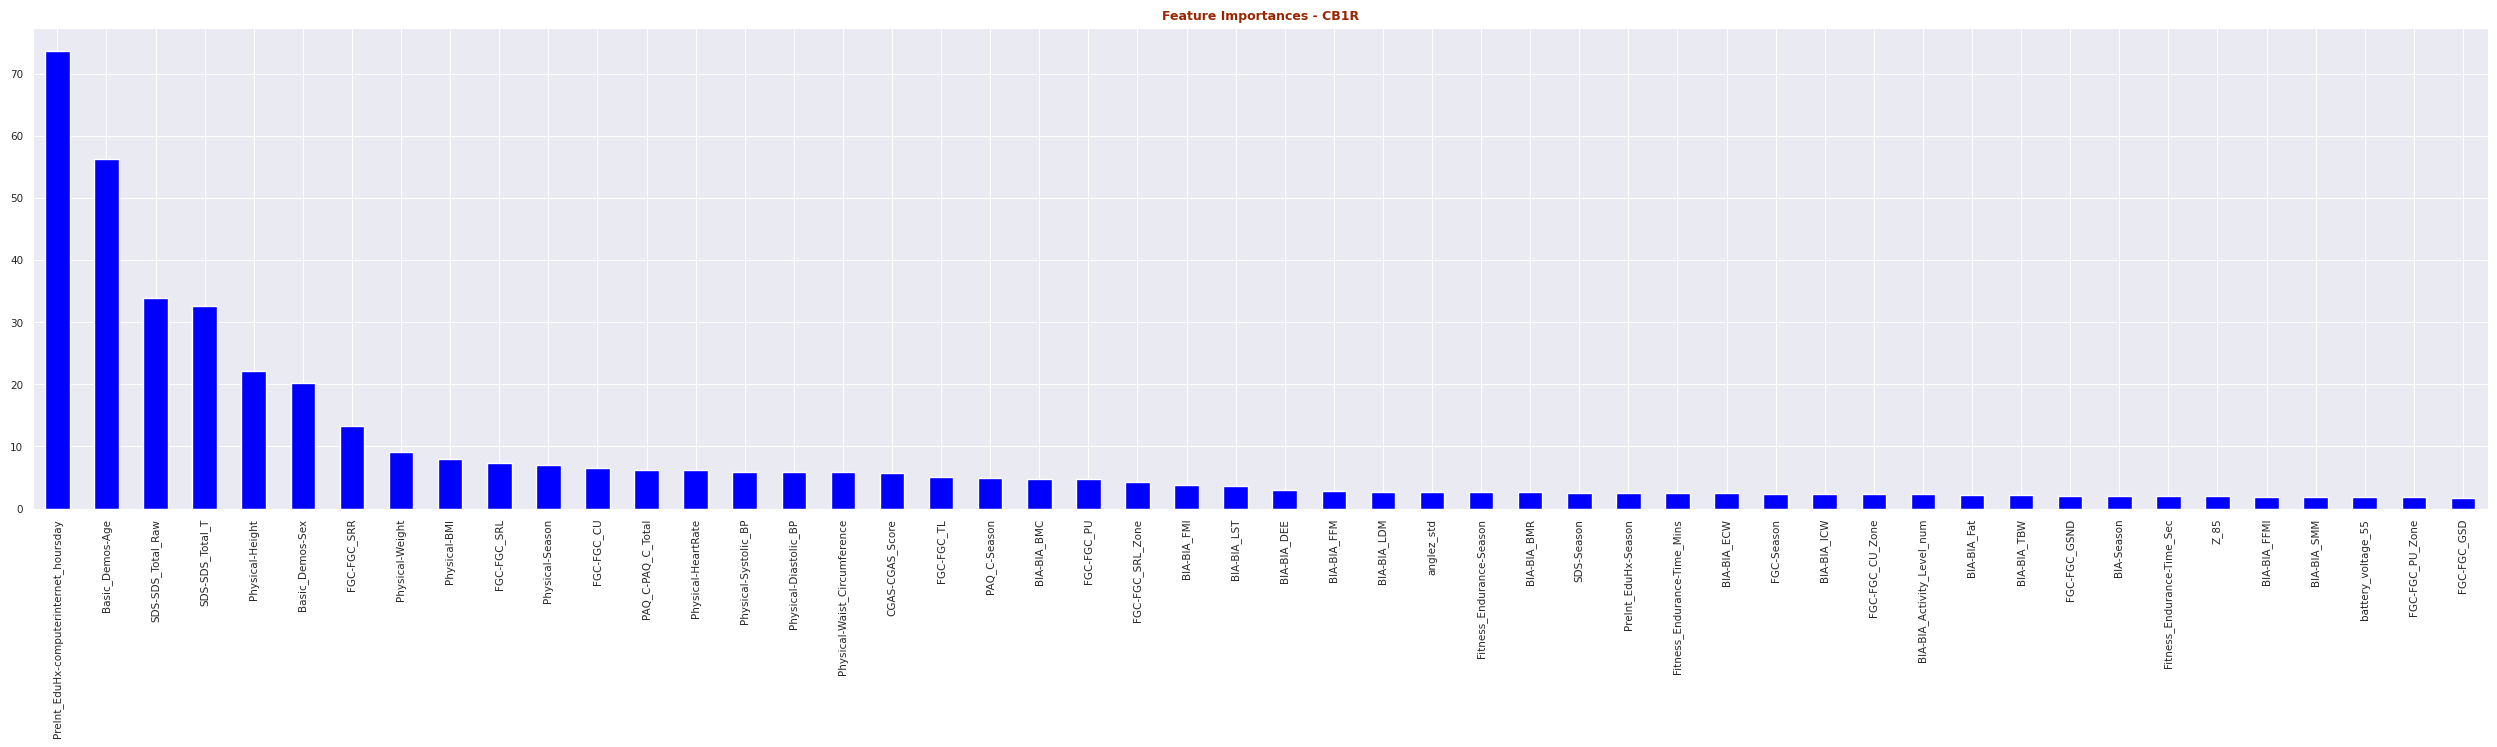



---> 1.320228 +- 0.039765 | OOF
---> 1.124280 +- 0.014029 | Train
---> Max best iteration = 151


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_18 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.408185 | Train = 1.247837 | Iter = 110 
CB1R Fold1           OOF = 1.383827 | Train = 1.232871 | Iter = 144 
CB1R Fold2           OOF = 1.438694 | Train = 1.221492 | Iter = 124 
CB1R Fold3           OOF = 1.448818 | Train = 1.217791 | Iter = 121 
CB1R Fold4           OOF = 1.483043 | Train = 1.213338 | Iter = 133 




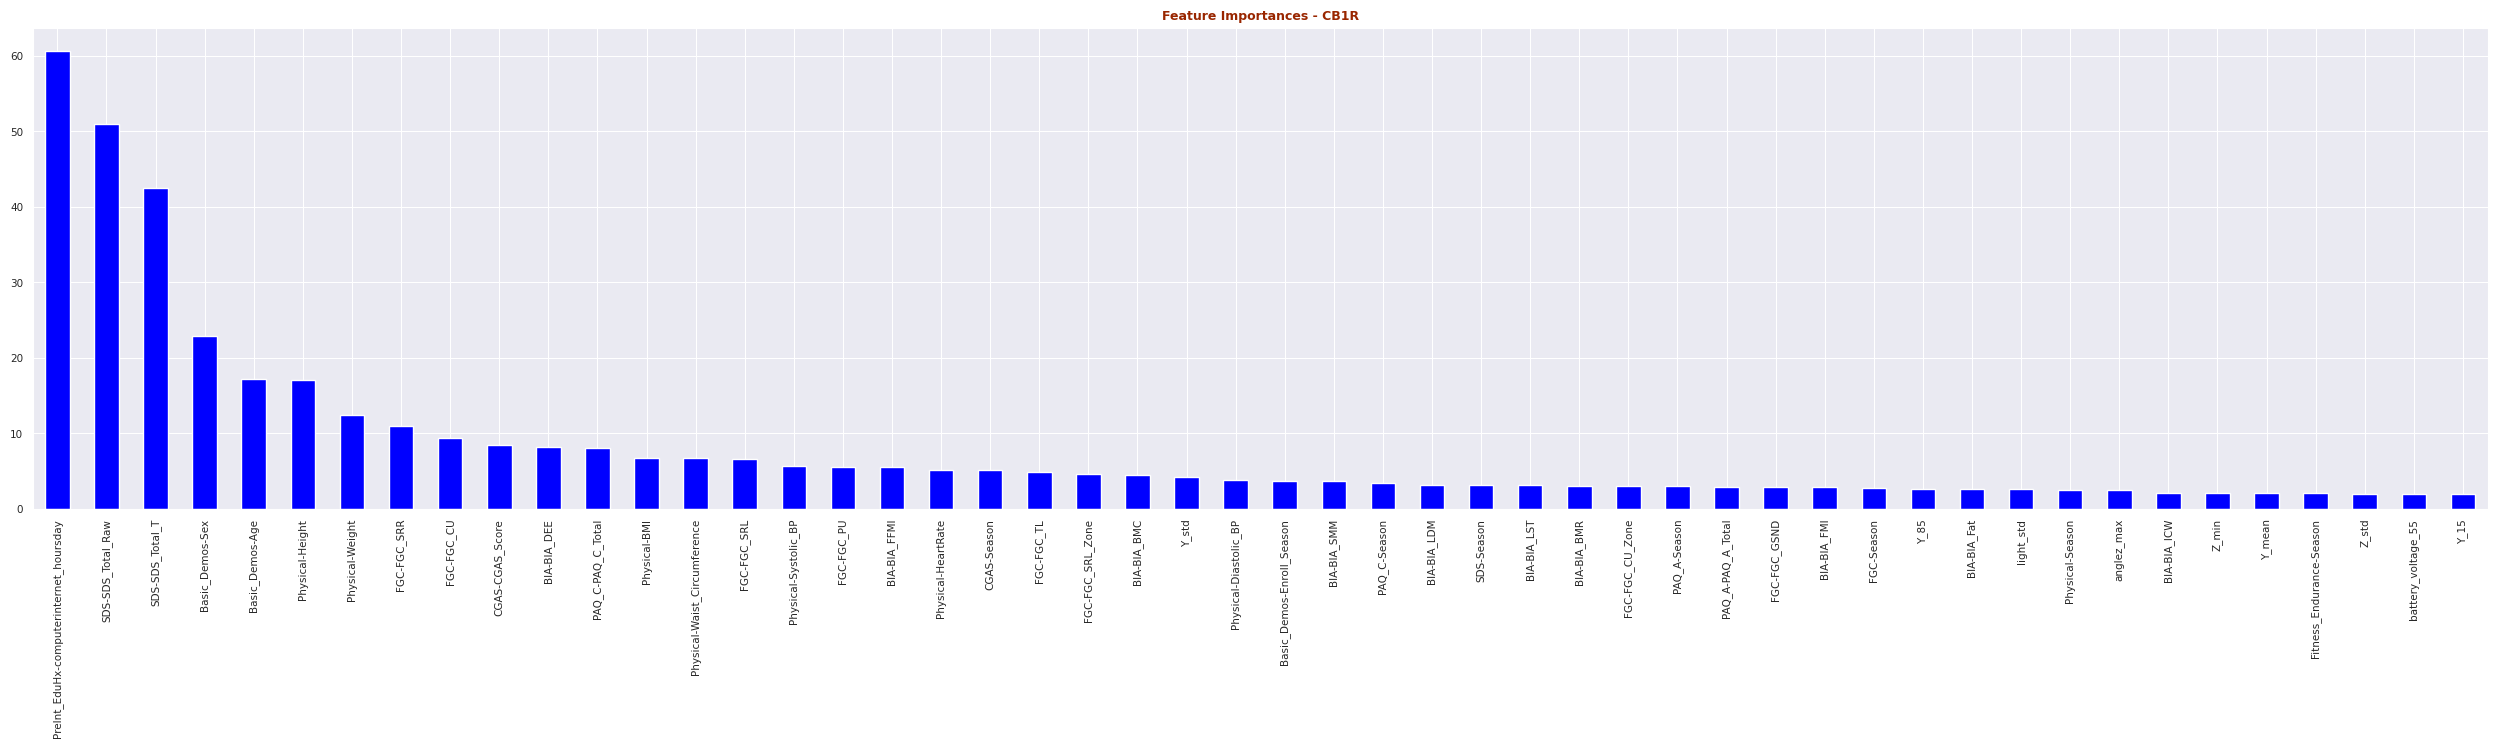



---> 1.432513 +- 0.034116 | OOF
---> 1.226666 +- 0.012409 | Train
---> Max best iteration = 144


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_19 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.276889 | Train = 1.013786 | Iter = 128 
CB1R Fold1           OOF = 1.204756 | Train = 1.053695 | Iter = 121 
CB1R Fold2           OOF = 1.190671 | Train = 1.036614 | Iter = 146 
CB1R Fold3           OOF = 1.263941 | Train = 1.017708 | Iter = 149 
CB1R Fold4           OOF = 1.221942 | Train = 1.091983 | Iter = 84 




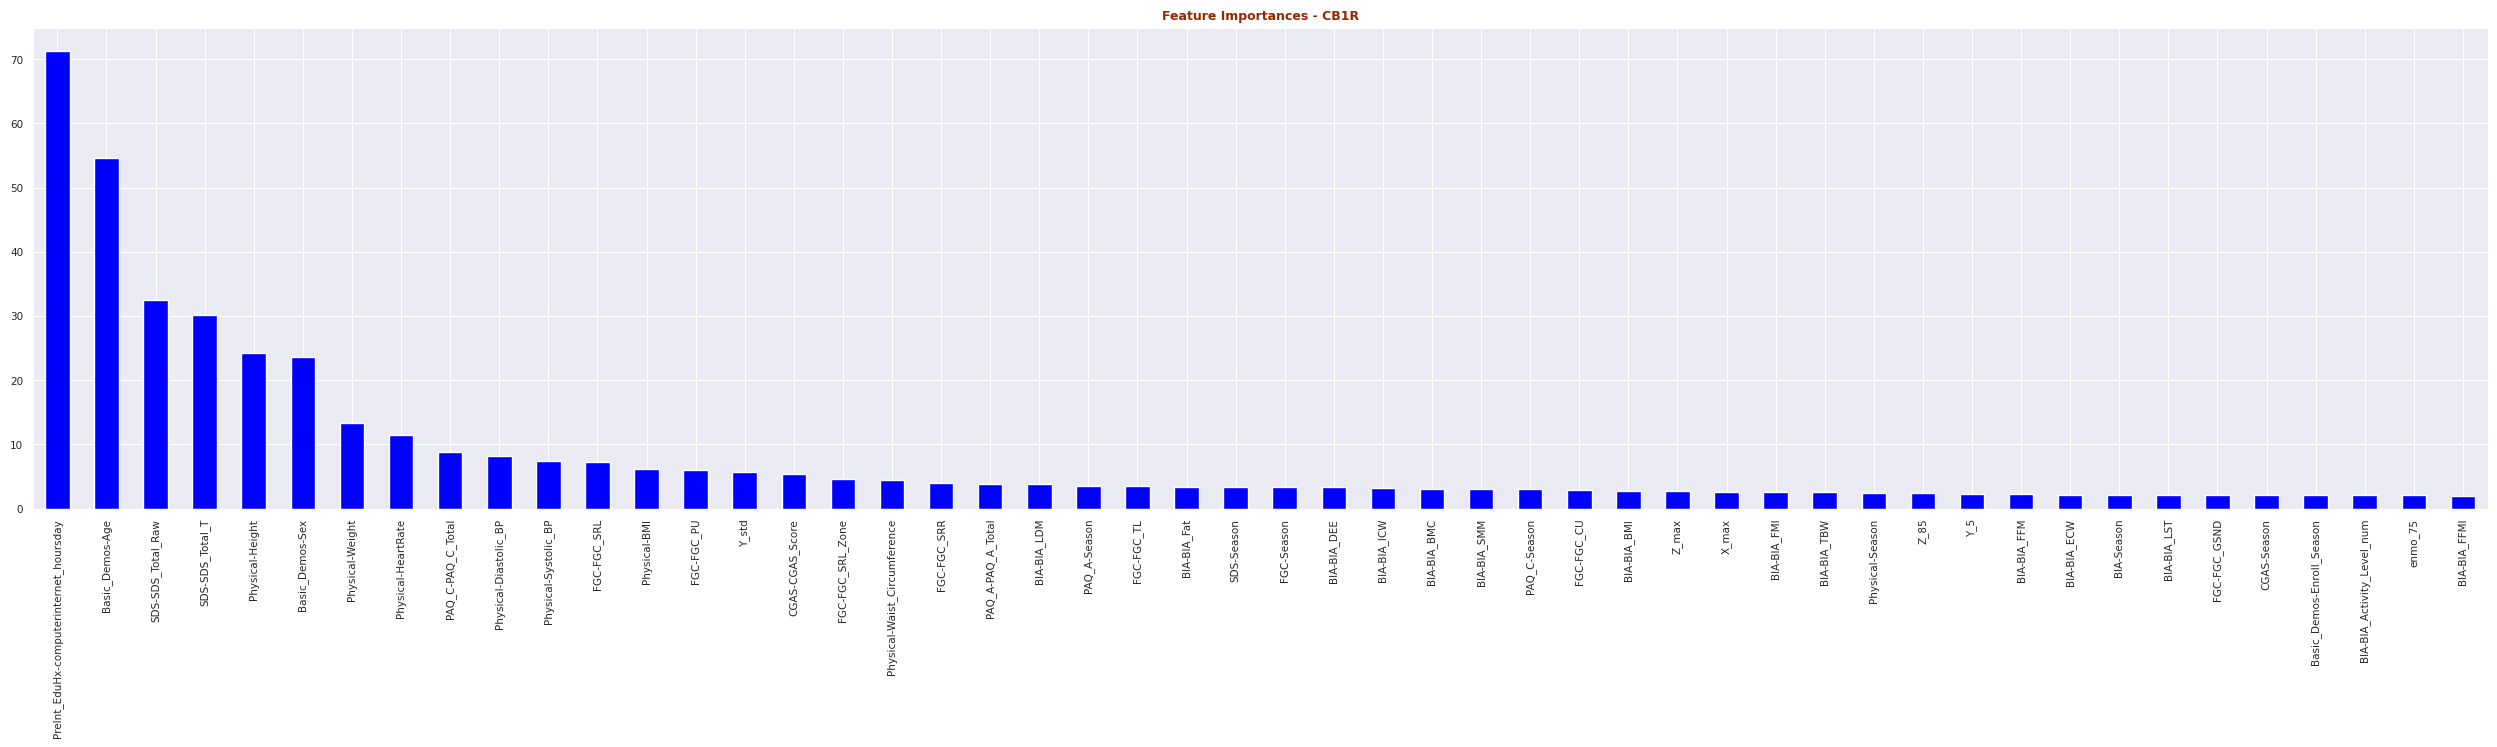



---> 1.231640 +- 0.033425 | OOF
---> 1.042757 +- 0.028451 | Train
---> Max best iteration = 149


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_20 ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 1.127024 | Train = 0.888705 | Iter = 145 
CB1R Fold1           OOF = 1.070555 | Train = 0.909052 | Iter = 142 
CB1R Fold2           OOF = 1.030464 | Train = 0.882217 | Iter = 175 
CB1R Fold3           OOF = 1.105170 | Train = 0.903612 | Iter = 138 
CB1R Fold4           OOF = 1.127201 | Train = 0.823192 | Iter = 259 




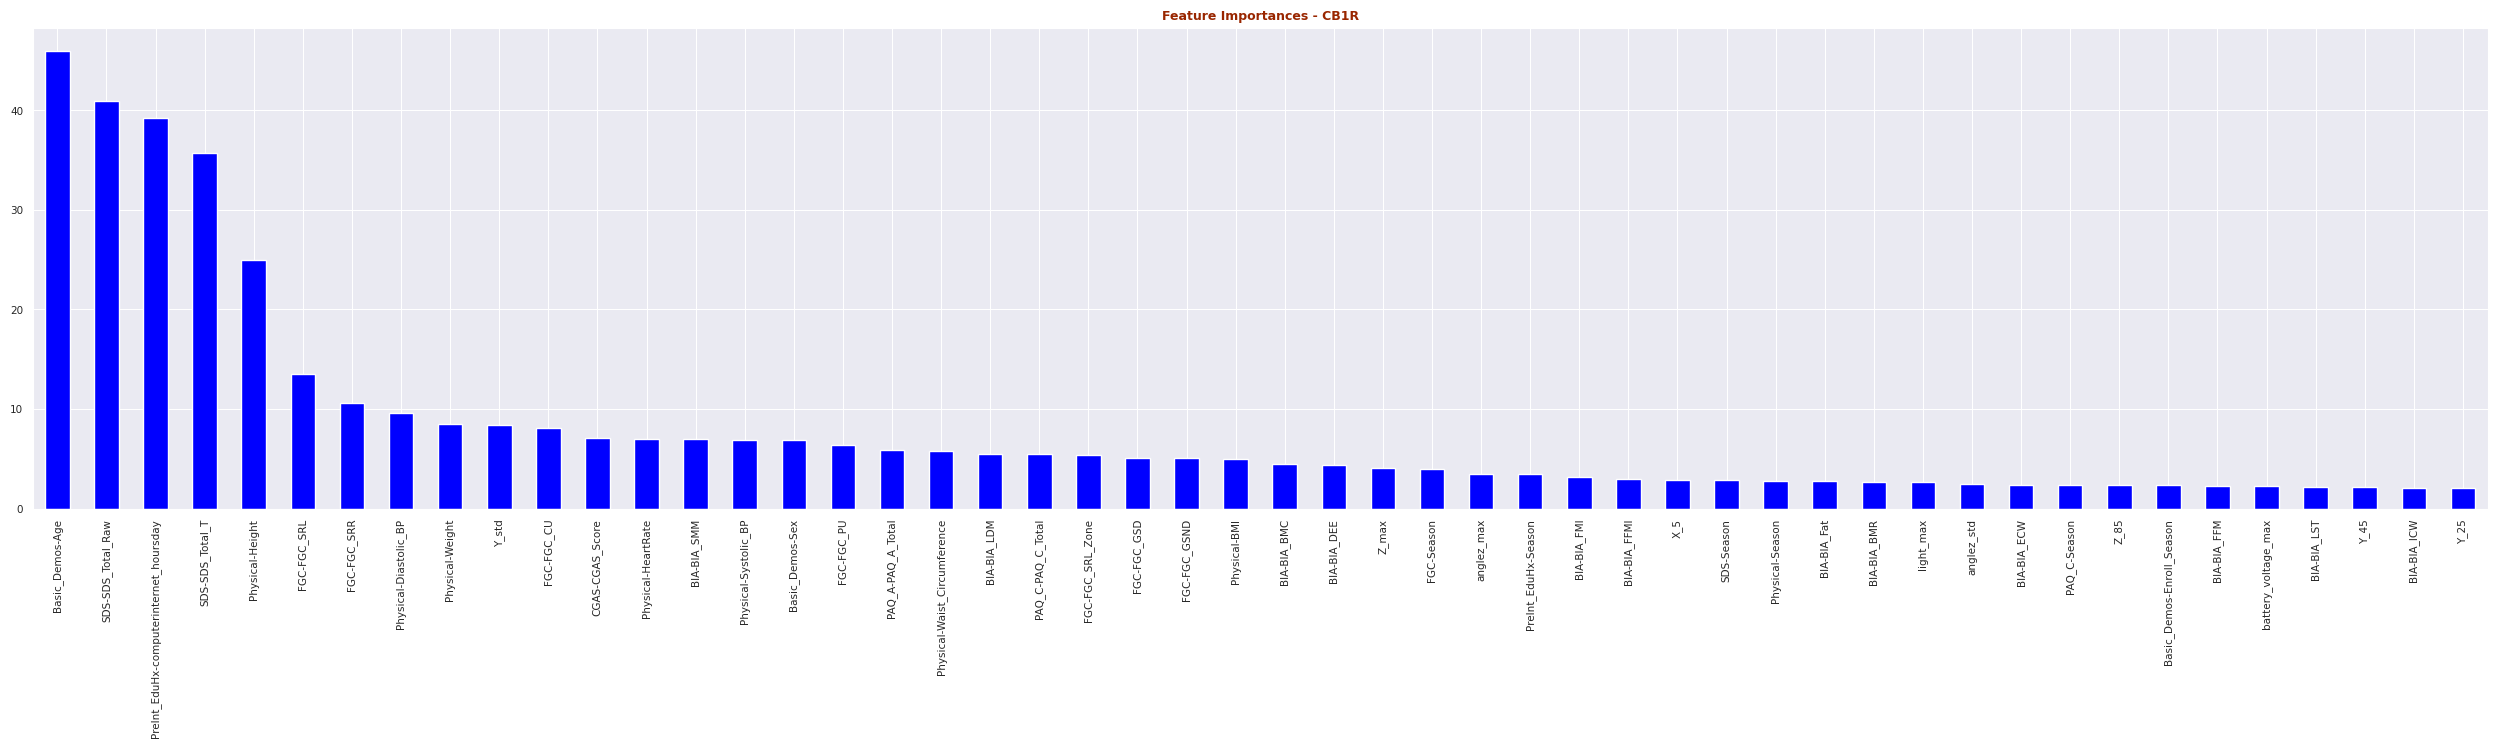



---> 1.092083 +- 0.037110 | OOF
---> 0.881356 +- 0.030660 | Train
---> Max best iteration = 259


  0%|          | 0/1 [00:00<?, ?it/s]


---------- CB1R MODEL TRAINING - PCIAT-PCIAT_Total ----------



0it [00:00, ?it/s]

CB1R Fold0           OOF = 17.517532 | Train = 14.286112 | Iter = 134 
CB1R Fold1           OOF = 16.804764 | Train = 12.884523 | Iter = 310 
CB1R Fold2           OOF = 16.791932 | Train = 14.103807 | Iter = 163 
CB1R Fold3           OOF = 17.231187 | Train = 13.717098 | Iter = 191 
CB1R Fold4           OOF = 17.435183 | Train = 13.209299 | Iter = 251 




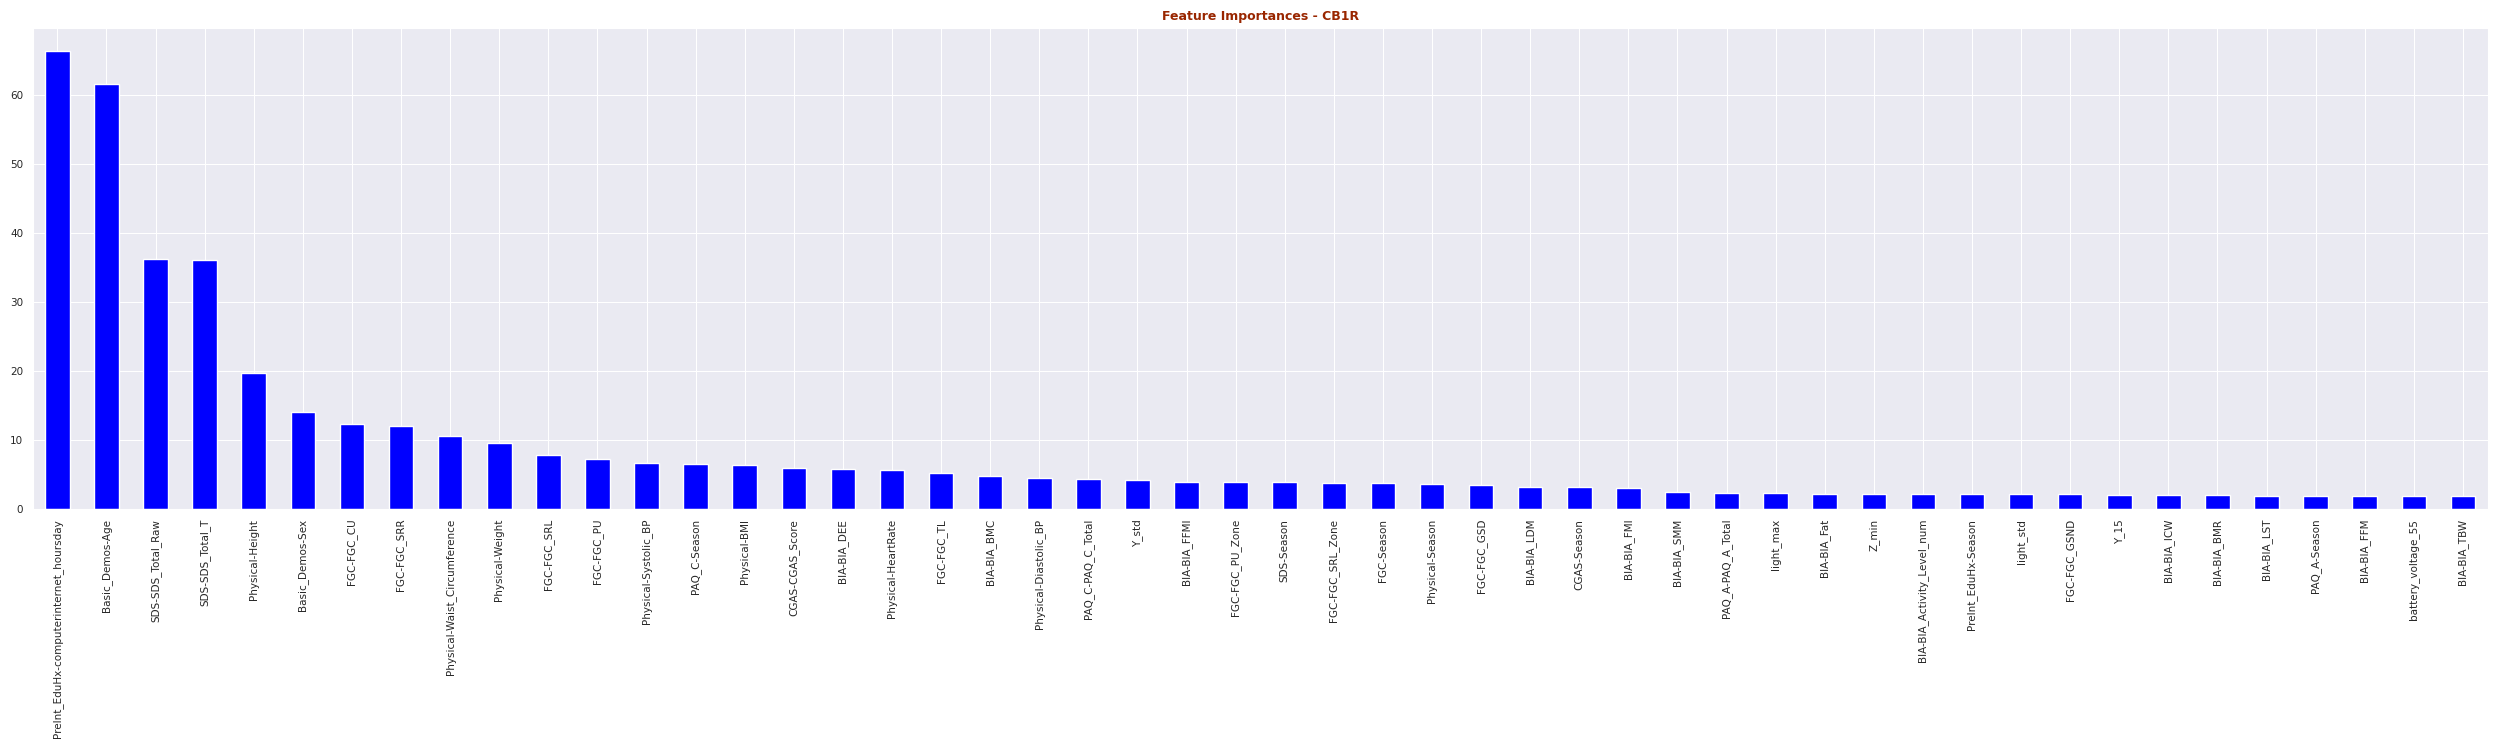



---> 17.156119 +- 0.306664 | OOF
---> 13.640168 +- 0.528161 | Train
---> Max best iteration = 310

RAM usage = 1.005 GB
CPU times: user 28min 4s, sys: 13min 32s, total: 41min 36s
Wall time: 12min 15s


In [16]:
%%time 

for tgt_nb, mytarget in tqdm(enumerate(targets)):
      
    # Creating CV scheme:-
    md = ModelTrainer(es = CFG.nbrnd_erly_stp, target = mytarget)

    for method, mdl in tqdm(Mdl_Master.items()):
        PrintColor(f"\n{'-' * 10} {method} MODEL TRAINING - {mytarget} {'-' * 10}\n", 
                   color = Fore.MAGENTA
                  )
        
        fitted_models, oof_preds, test_preds, ftreimp, mdl_best_iter =  \
        md.MakeOfflineModel(
            mytrain[sel_cols],
            mytrain[mytarget],
            mytrain["fold_nb"],
            mytest,
            clone(mdl),
            method,
            test_preds_req   = True,
            ftreimp_plot_req = True,
            ntop = 50,
        ) 
    
        # Integrating data    
        OOF_Preds[f"{method}_{mytarget}"]    = oof_preds
        Mdl_Preds[f"{method}_{mytarget}"]    = test_preds
        FtreImp[f"{method}_{mytarget}"]      = ftreimp
        FittedModels[f"{method}_{mytarget}"] = fitted_models
    
        del fitted_models, oof_preds, test_preds, ftreimp, mdl_best_iter
        _ = utils.CleanMemory()
    
PrintColor(utils.CleanMemory())    

## **THRESHOLD TUNING**

In this section, we try and establish the best CV based cutoffs to convert the continuous predictions to labels for the target prediction <br>
Here, we use the predicted values for the proxy target **PCIAT-PCIAT_Total** as a base column and unearth the best values for **sii**, our actual target

In [17]:
%%time 

OOF_Preds = pd.DataFrame.from_dict(OOF_Preds, orient = "columns")
Mdl_Preds = pd.DataFrame.from_dict(Mdl_Preds, orient = "columns")

# Creating the mean PCIAT_Total from component models and direct predictions:-
oof_preds = \
np.mean(
    np.stack(
        [OOF_Preds.iloc[:, 0: -1].sum(axis=1).values, 
         OOF_Preds.iloc[:, -1].values
        ],axis=1
    ), axis=1
)

mdl_preds = \
np.mean(
    np.stack(
        [Mdl_Preds.iloc[:, 0: -1].sum(axis=1).values, 
         Mdl_Preds.iloc[:, -1].values
        ],axis=1
    ), axis=1
)

CPU times: user 6.72 ms, sys: 953 µs, total: 7.67 ms
Wall time: 6.43 ms



---> Final ensemble OOF score = 0.457912




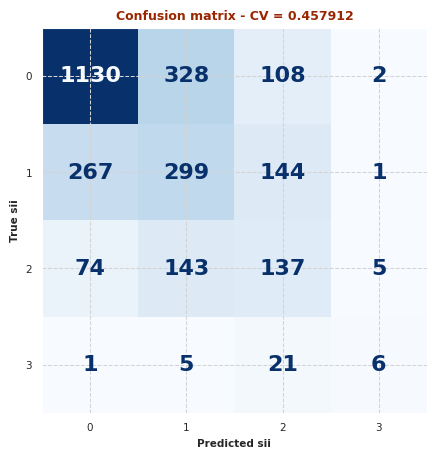

CPU times: user 6.25 s, sys: 165 ms, total: 6.42 s
Wall time: 6.17 s


In [18]:
%%time 

mytuner = OptimizedRounder(n_classes = 4, n_trials = CFG.ntrials)
ytrain  = np.uint8(mytrain[CFG.target])

mytuner.fit(oof_preds, ytrain)
ens_preds  = mytuner.predict(oof_preds)
test_preds = mytuner.predict(mdl_preds)

# Displaying the confusion matrix 
score = utils.ScoreMetric(ytrain, ens_preds)
PrintColor(f"\n---> Final ensemble OOF score = {score :.6f}\n\n")

fig, ax = plt.subplots(1,1, figsize = (5,5))
disp = \
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytrain, ens_preds),  
    display_labels = list(range(4))
)

disp.plot(
    cmap = "Blues", 
    ax = ax, 
    colorbar = False, 
    xticks_rotation = 0,
    text_kw = {"fontweight": "bold", 
               "fontfamily": "Cambria", 
               "fontsize"  : 16,
              }
)
ax.set_title(
    f"Confusion matrix - CV = {score :.6f}", **CFG.title_specs
)
ax.grid(**CFG.grid_specs)
ax.set(ylabel = f"True {CFG.target}", 
       xlabel = f"Predicted {CFG.target}", 
      )
plt.show()

_ = utils.CleanMemory()

# **SUBMISSION**

In [19]:
%%time 

print()
display(
    OOF_Preds.head().style.format(precision = 3).set_caption("OOF Predictions")
)

print()
display(
    Mdl_Preds.head().style.format(precision = 3).set_caption("Model Predictions")
)

sub_fl.with_columns(
    pl.Series(CFG.target, test_preds.flatten(), pl.UInt8)
).write_csv("submission.csv")

print()
!ls 
print(f"\n\n---> Submission file\n\n")
!head submission.csv

PrintColor(utils.CleanMemory())

,CB1R_PCIAT-PCIAT_01,CB1R_PCIAT-PCIAT_02,CB1R_PCIAT-PCIAT_03,CB1R_PCIAT-PCIAT_04,CB1R_PCIAT-PCIAT_05,CB1R_PCIAT-PCIAT_06,CB1R_PCIAT-PCIAT_07,CB1R_PCIAT-PCIAT_08,CB1R_PCIAT-PCIAT_09,CB1R_PCIAT-PCIAT_10,CB1R_PCIAT-PCIAT_11,CB1R_PCIAT-PCIAT_12,CB1R_PCIAT-PCIAT_13,CB1R_PCIAT-PCIAT_14,CB1R_PCIAT-PCIAT_15,CB1R_PCIAT-PCIAT_16,CB1R_PCIAT-PCIAT_17,CB1R_PCIAT-PCIAT_18,CB1R_PCIAT-PCIAT_19,CB1R_PCIAT-PCIAT_20,CB1R_PCIAT-PCIAT_Total
0,2.053,2.189,2.647,1.046,2.124,0.582,0.114,0.926,0.827,1.070,1.898,0.203,1.299,0.475,1.003,1.404,2.018,1.448,1.180,0.599,28.154
1,2.357,1.498,1.948,0.368,1.894,0.551,0.119,0.748,0.692,1.032,0.915,0.137,1.272,0.757,1.231,1.619,1.328,1.495,0.916,0.655,20.195
2,2.866,2.724,2.722,0.813,2.952,0.839,0.314,1.321,0.916,1.568,1.731,0.189,1.234,1.047,1.845,1.507,1.817,1.824,1.149,1.162,31.461
3,2.009,1.711,1.845,0.613,1.763,0.661,0.173,0.681,0.466,0.814,0.942,0.130,0.809,0.510,0.821,0.806,1.086,0.881,0.753,0.599,16.624
4,2.467,2.433,2.565,1.292,2.512,1.540,0.921,1.399,1.572,1.370,1.626,0.365,1.247,1.266,1.462,1.216,1.747,1.426,1.249,1.062,31.324


,CB1R_PCIAT-PCIAT_01,CB1R_PCIAT-PCIAT_02,CB1R_PCIAT-PCIAT_03,CB1R_PCIAT-PCIAT_04,CB1R_PCIAT-PCIAT_05,CB1R_PCIAT-PCIAT_06,CB1R_PCIAT-PCIAT_07,CB1R_PCIAT-PCIAT_08,CB1R_PCIAT-PCIAT_09,CB1R_PCIAT-PCIAT_10,CB1R_PCIAT-PCIAT_11,CB1R_PCIAT-PCIAT_12,CB1R_PCIAT-PCIAT_13,CB1R_PCIAT-PCIAT_14,CB1R_PCIAT-PCIAT_15,CB1R_PCIAT-PCIAT_16,CB1R_PCIAT-PCIAT_17,CB1R_PCIAT-PCIAT_18,CB1R_PCIAT-PCIAT_19,CB1R_PCIAT-PCIAT_20,CB1R_PCIAT-PCIAT_Total
0,2.127,2.156,2.744,0.721,2.298,0.462,0.138,1.477,0.563,0.744,1.975,0.155,1.447,0.676,1.278,1.508,2.368,1.608,1.298,0.722,29.702
1,2.239,1.471,1.792,0.407,1.646,0.546,0.156,0.706,0.652,1.034,0.943,0.124,1.096,0.634,1.173,1.444,1.242,1.478,0.815,0.622,18.942
2,2.729,2.572,2.544,0.736,2.695,0.869,0.364,1.335,0.827,1.373,1.645,0.174,1.309,1.019,1.672,1.425,1.743,1.751,1.176,1.042,29.944
3,2.214,1.610,2.071,0.527,2.121,0.703,0.184,0.854,0.619,0.968,1.220,0.140,0.956,0.469,0.853,1.034,1.463,1.170,1.131,0.614,20.083
4,1.940,2.208,2.489,1.163,2.249,1.500,1.443,1.851,1.819,1.342,2.576,0.322,1.086,1.538,1.382,1.091,1.516,1.250,1.244,0.838,31.979



catboost_info  myimports.py  submission.csv  training.py


---> Submission file


id,sii
00008ff9,2
000fd460,0
00105258,2
00115b9f,0
0016bb22,2
001f3379,2
0038ba98,2
0068a485,0
0069fbed,3

RAM usage = 1.008 GB
CPU times: user 210 ms, sys: 104 ms, total: 315 ms
Wall time: 2.43 s
